<a href="https://www.kaggle.com/code/vicmangiltafolla/titanic-hiperparam-tunning-with-voting-classifier?scriptVersionId=140624342" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **Titanic - Machine Learning from Disaster**


#  Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from sklearn.linear_model import LogisticRegression, Perceptron, RidgeClassifier, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import RobustScaler, Normalizer, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.gridspec as gridspec
import seaborn as sns
import time
from joblib import dump, load

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Functions 

Define the functions that will help later in the notebook to simplify processes and make cleaner code

In [2]:
def countNan(df):
    for x in df:
        No_Nan_count = df[x].isna().value_counts()[0]
        Nan_count = len(df) - No_Nan_count
        if Nan_count > 0:
            print("Elements in {}\n".format(x)) 
            print("There are {} Nan values".format(Nan_count))
            print("There are {} No Nan values".format(No_Nan_count))
            print("---------------------------")
    print("___________________________") 
    
class FinalDataProcessor(BaseEstimator, TransformerMixin):
    '''Encode, scal and replace Nan values with any transformer using the fit/transform methods.
    
        The input should be an array-like of integers for the numeric transformation, numeric
        or string for the categorical one.
        '''
    def __init__(self,
                encoder=None,
                imputer=None,
                scaler=None,
                to_scal_cols=None,
                to_encod_cols=None):
        #Set transformers
        self.encoder = encoder
        self.imputer =imputer
        self.scaler = scaler
        self.to_scal_cols = to_scal_cols
        self.to_encod_cols = to_encod_cols
        
        #Set pipelines with the transformers
        num_pipeline = Pipeline([
                             ("imputer", self.imputer),
                             ("scaler", self.scaler)
        ])
        cat_pipeline = Pipeline([
                                ("imputer", self.imputer),
                                ("encoder", self.encoder)
        ])
        self._final_pipeline = ColumnTransformer([
            ("num", num_pipeline, self.to_scal_cols),
            ("cat", cat_pipeline, self.to_encod_cols)
        ])
    def fit(self, X, y=None):
        self._final_pipeline.fit(X)
        return self
    def transform(self, X, y=None):
        X = self._final_pipeline.transform(X)
        #Return a complete dataset with all the transformed values
        return pd.DataFrame(X, columns=(self._final_pipeline.get_feature_names_out()))

    
def TextProcess(row):
    #Clean the name attribute from punctuation marks 
    row = row.lower().replace('.', '')
    titles = ["master", "mr", "miss", "mrs", "ms", "sir", "lady", "dr", "rev", "fr", "capt", "col", "mme",
               "major", "mlle", "jonkheer", "countess", "uruchurtu", "dona"]
    #Replace the Name attribute with their corresponding title
    for name in str(row).split():
        if name in titles:
            return name

def predict(X_train,y_train,X_val, y_val,model):
    #Predicts and contrast different scores with the training and validation set
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    print("---Training set---\n")
    print("\t-Precision Score: {:.3f}\n".format(precision_score(y_train,y_train_pred)))
    print("\t-Accuracy Score: {:.3f}\n".format(accuracy_score(y_train,y_train_pred)))
    print("\t-F1 Score: {:.3f}\n".format(f1_score(y_train,y_train_pred)))
    print("\t-Recall Score: {:.3f}\n".format(recall_score(y_train, y_train_pred)))
    print("---Validation set---\n")
    print("\t-Precision Score: {:.3f}\n".format(precision_score(y_val,y_val_pred)))
    print("\t-Accuracy Score: {:.3f}\n".format(accuracy_score(y_val,y_val_pred)))
    print("\t-F1 Score: {:.3f}\n".format(f1_score(y_val,y_val_pred)))
    print("\t-Recall Score: {:.3f}\n".format(recall_score(y_val, y_val_pred)))

def CreateSub(origindf, preddf, model ,filename):
    #Creates a CSV file containing the predictions made by the final model to a 'Submissions' 
    preds = model.predict(preddf)
    passid = origindf["PassengerId"].copy()
    df_pred = pd.DataFrame(preds, columns=["Survived"])
    df_pred = pd.concat([passid,df_pred], axis="columns")
    df_pred.to_csv('/kaggle/working/' + filename + ".csv",index=False)

def PlotSurvCorrelation(df,column):
    #Plots the count of people who survived and didn't for each unique value in the selected column 

    #Get the names of the categories
    names = tuple(sorted(df[column].dropna().unique()))
    surv_dict = {'Survived': [], 'Not Survived': []}
    #Add the number of survivors in the dictionary for each category
    for name in names: 
        surv_dict['Survived'].append(len(df[column][df[column]==name][df["Survived"]==1]))
        surv_dict['Not Survived'].append(len(df[column][df[column]==name][df["Survived"]==0]))
    surv_dict['Survived'] = tuple(surv_dict['Survived'])
    surv_dict['Not Survived'] = tuple(surv_dict['Not Survived'])
    x = np.arange(len(names))
    multiplier = 0
    width = 0.25
    fig, ax = plt.subplots(figsize=(20,10))
    #Creates the bars setting the height as the count from before
    for surv, count in surv_dict.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, count, width, label=surv)
        ax.bar_label(rects, padding=3)
        multiplier +=1
    ax.set_ylabel('Count')
    ax.set_title('Survival count by {}'.format(column))
    ax.set_xticks(x + width, names)
    ax.legend(loc='upper center')

# Dataset reading

Use some basic pandas built-in methods to gain some insights about the data

In [3]:
df_train = pd.read_csv("/kaggle/input/titanic/train.csv")
df_test = pd.read_csv("/kaggle/input/titanic/test.csv")

In [4]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [8]:
#Counting of NaN elements in our dataset entries
countNan(df_train)
countNan(df_test)

Elements in Age

There are 177 Nan values
There are 714 No Nan values
---------------------------
Elements in Cabin

There are 204 Nan values
There are 687 No Nan values
---------------------------
Elements in Embarked

There are 2 Nan values
There are 889 No Nan values
---------------------------
___________________________
Elements in Age

There are 86 Nan values
There are 332 No Nan values
---------------------------
Elements in Fare

There are 1 Nan values
There are 417 No Nan values
---------------------------
Elements in Cabin

There are 91 Nan values
There are 327 No Nan values
---------------------------
___________________________


# Data visualization

Get some graphical information about how some features correlate with each other 

### Fare vs. Survived 

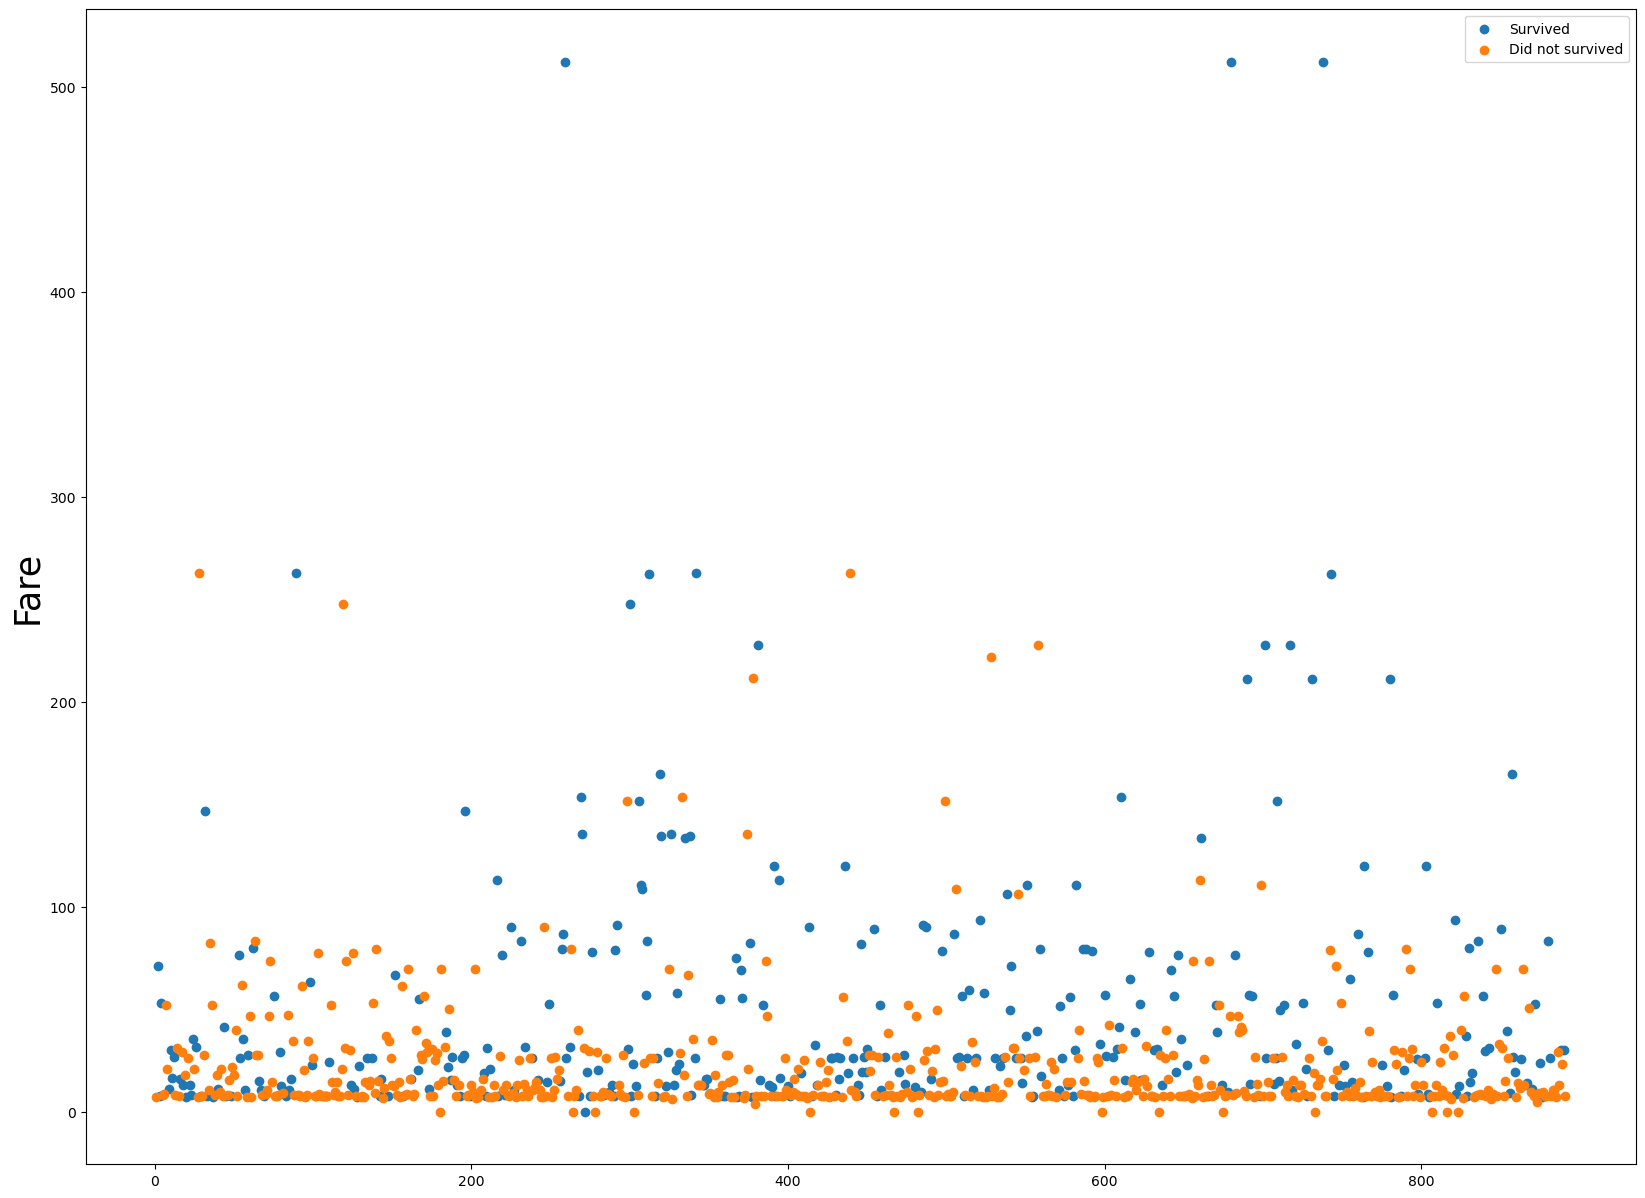

In [9]:
fig , ax= plt.subplots(figsize=(20,15))
ax.scatter(df_train["PassengerId"][df_train["Survived"] == 1],
            df_train["Fare"][df_train["Survived"] == 1], label="Survived")
ax.scatter( df_train["PassengerId"][df_train["Survived"] == 0],
            df_train["Fare"][df_train["Survived"] == 0], label="Did not survived")
ax.set_ylabel("Fare", fontsize=25)
ax.legend()
plt.show()


#### Fare distribution

/tmp/ipykernel_20/836008003.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_train["Fare"][df_train["Survived"] == 1], kde_kws={"label": "Survived"})
/tmp/ipykernel_20/836008003.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_train["Fare"][df_train['Survived'] == 0], kde_kws={"label

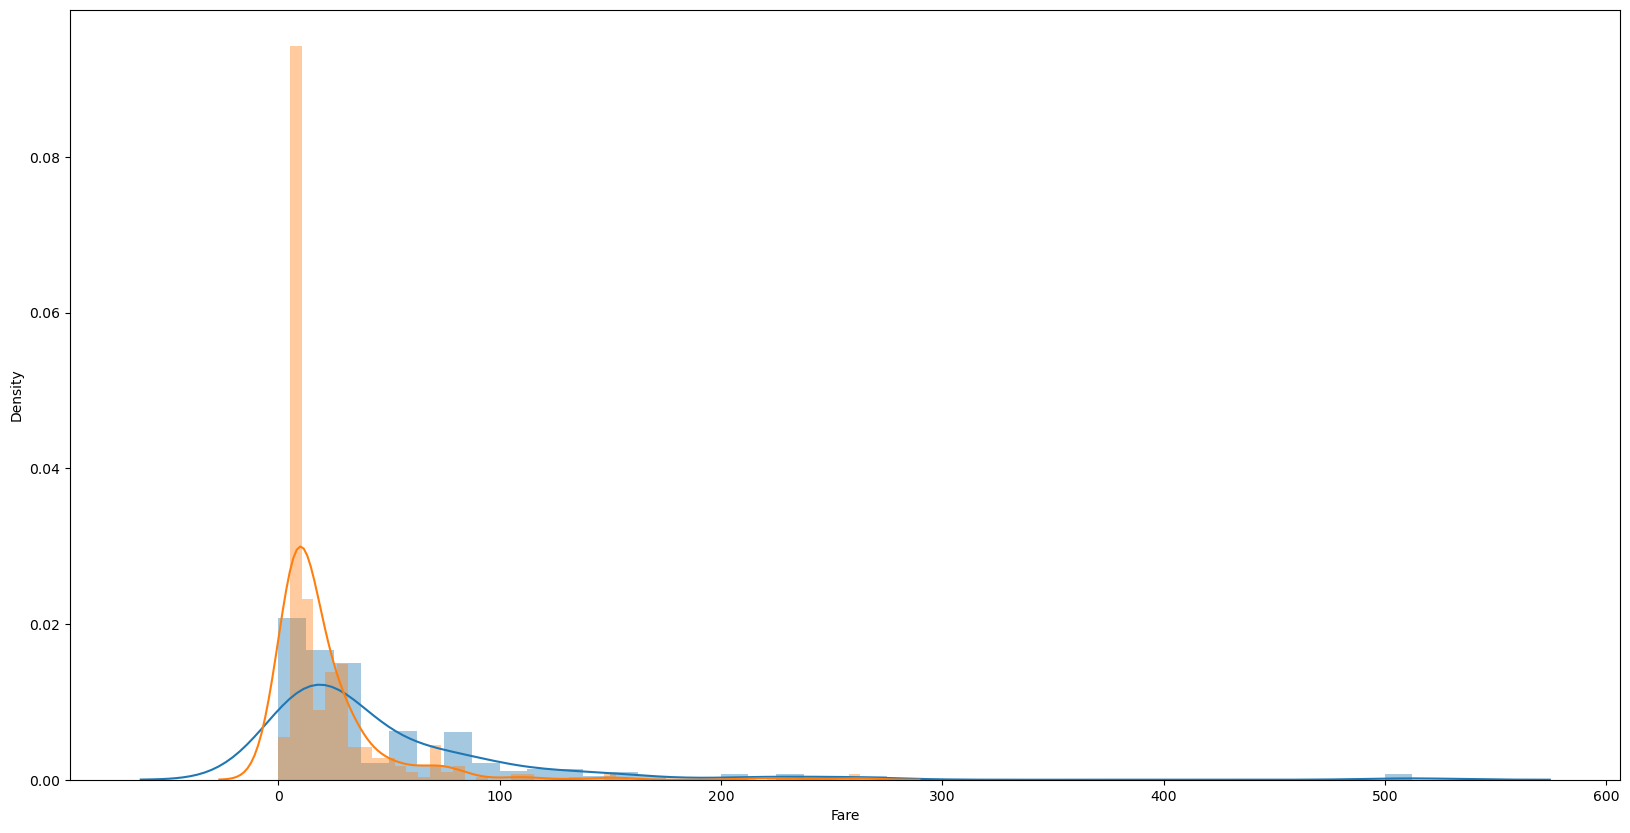

In [10]:
plt.figure(figsize=(20,10))
sns.distplot(df_train["Fare"][df_train["Survived"] == 1], kde_kws={"label": "Survived"})
sns.distplot(df_train["Fare"][df_train['Survived'] == 0], kde_kws={"label": "Did not Survived"})
plt.show()

### Fare vs Pclass 

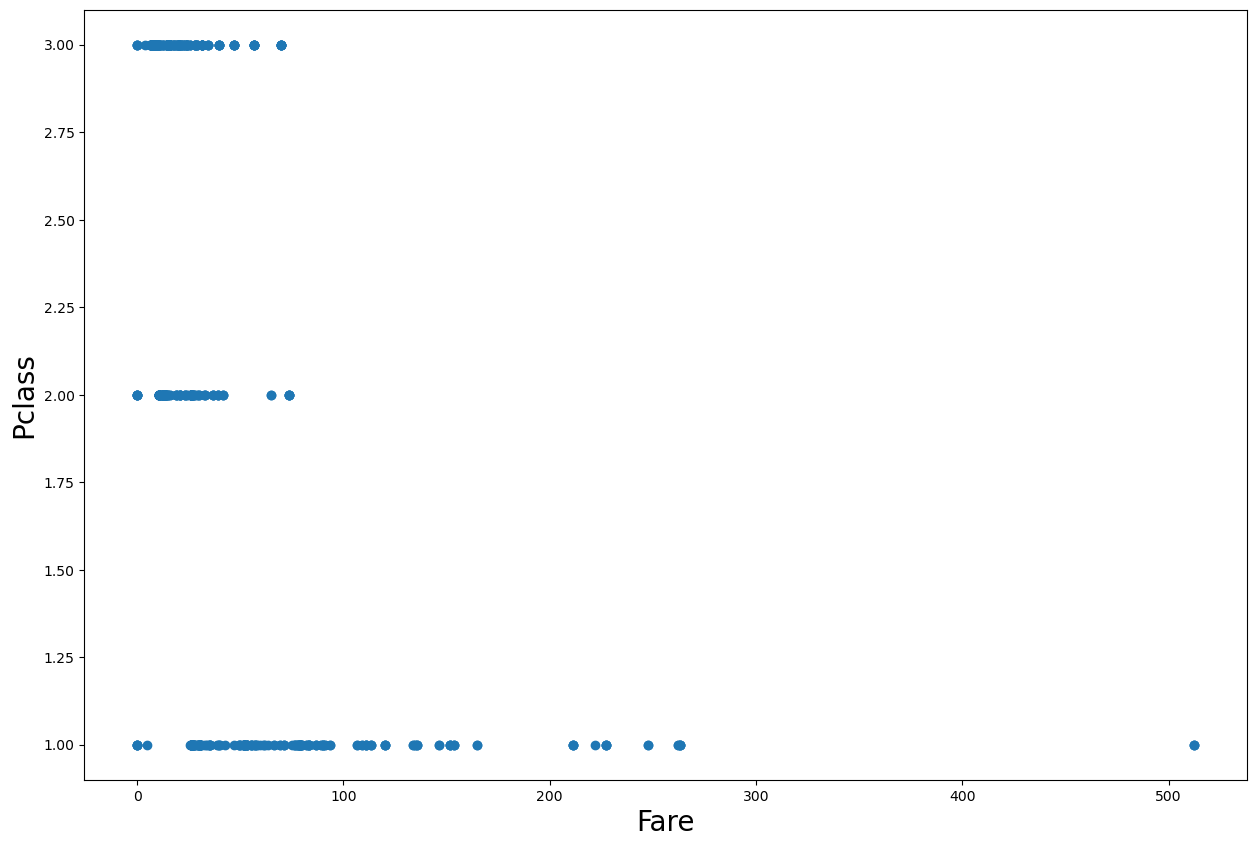

In [11]:
fig , ax= plt.subplots(figsize=(15,10))
ax.scatter(df_train["Fare"],df_train["Pclass"])
ax.set_xlabel("Fare",fontsize=20)
ax.set_ylabel("Pclass",fontsize=20)
plt.show()

Now compare the unique values in each attribute and see how do they relate with the survival of the passenger

### Pclass vs. Survived

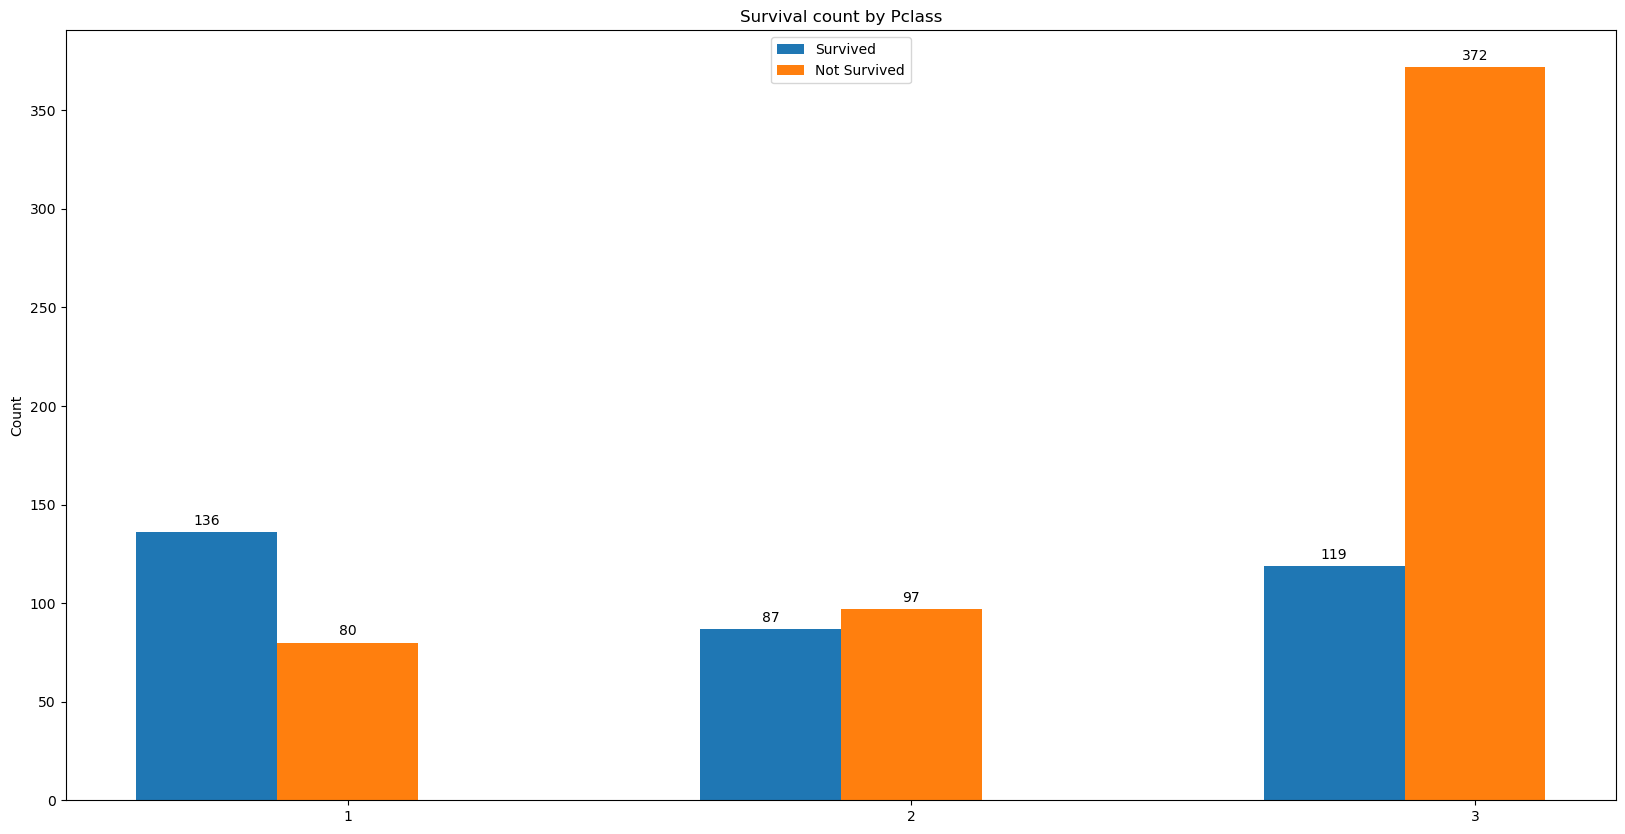

In [12]:
PlotSurvCorrelation(df_train,"Pclass")

### SibSp vs. Survived

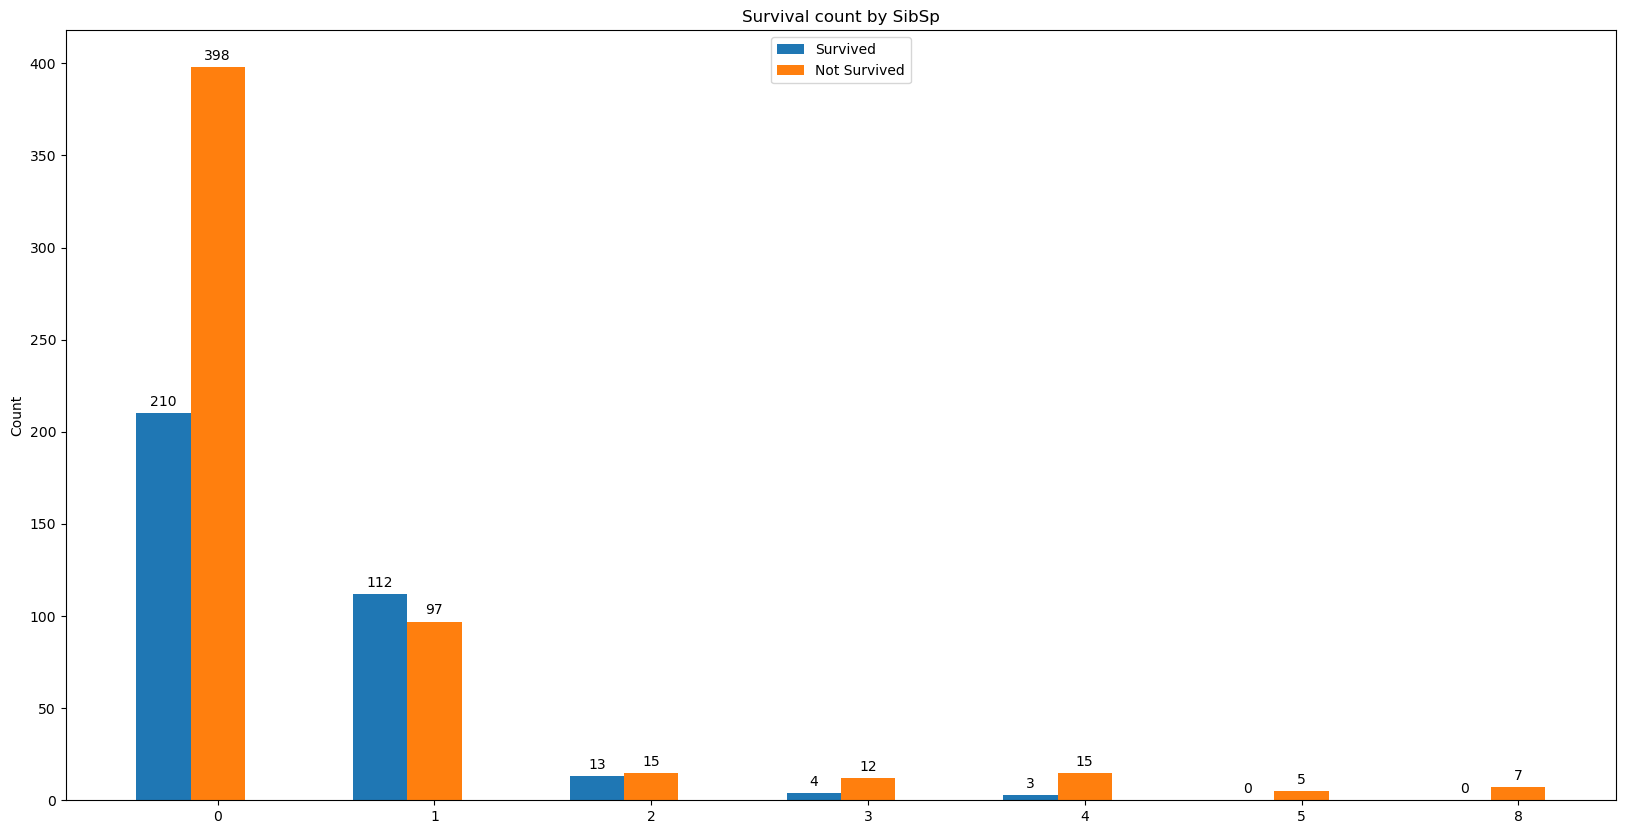

In [13]:
PlotSurvCorrelation(df_train,"SibSp")

### Parch vs Survived 

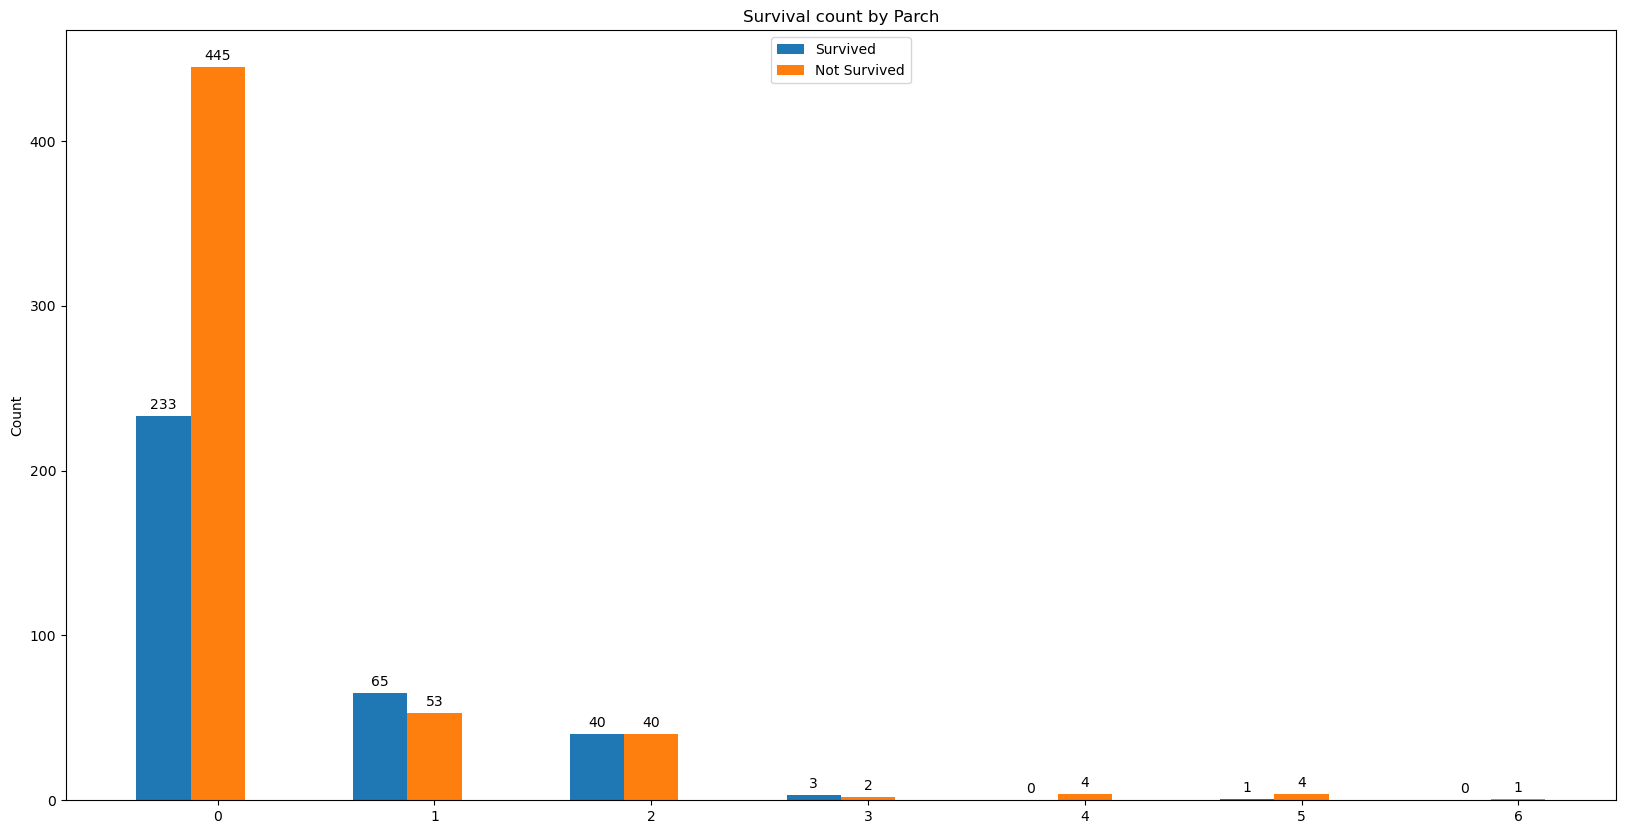

In [14]:
PlotSurvCorrelation(df_train,"Parch")

### Age vs Survived 

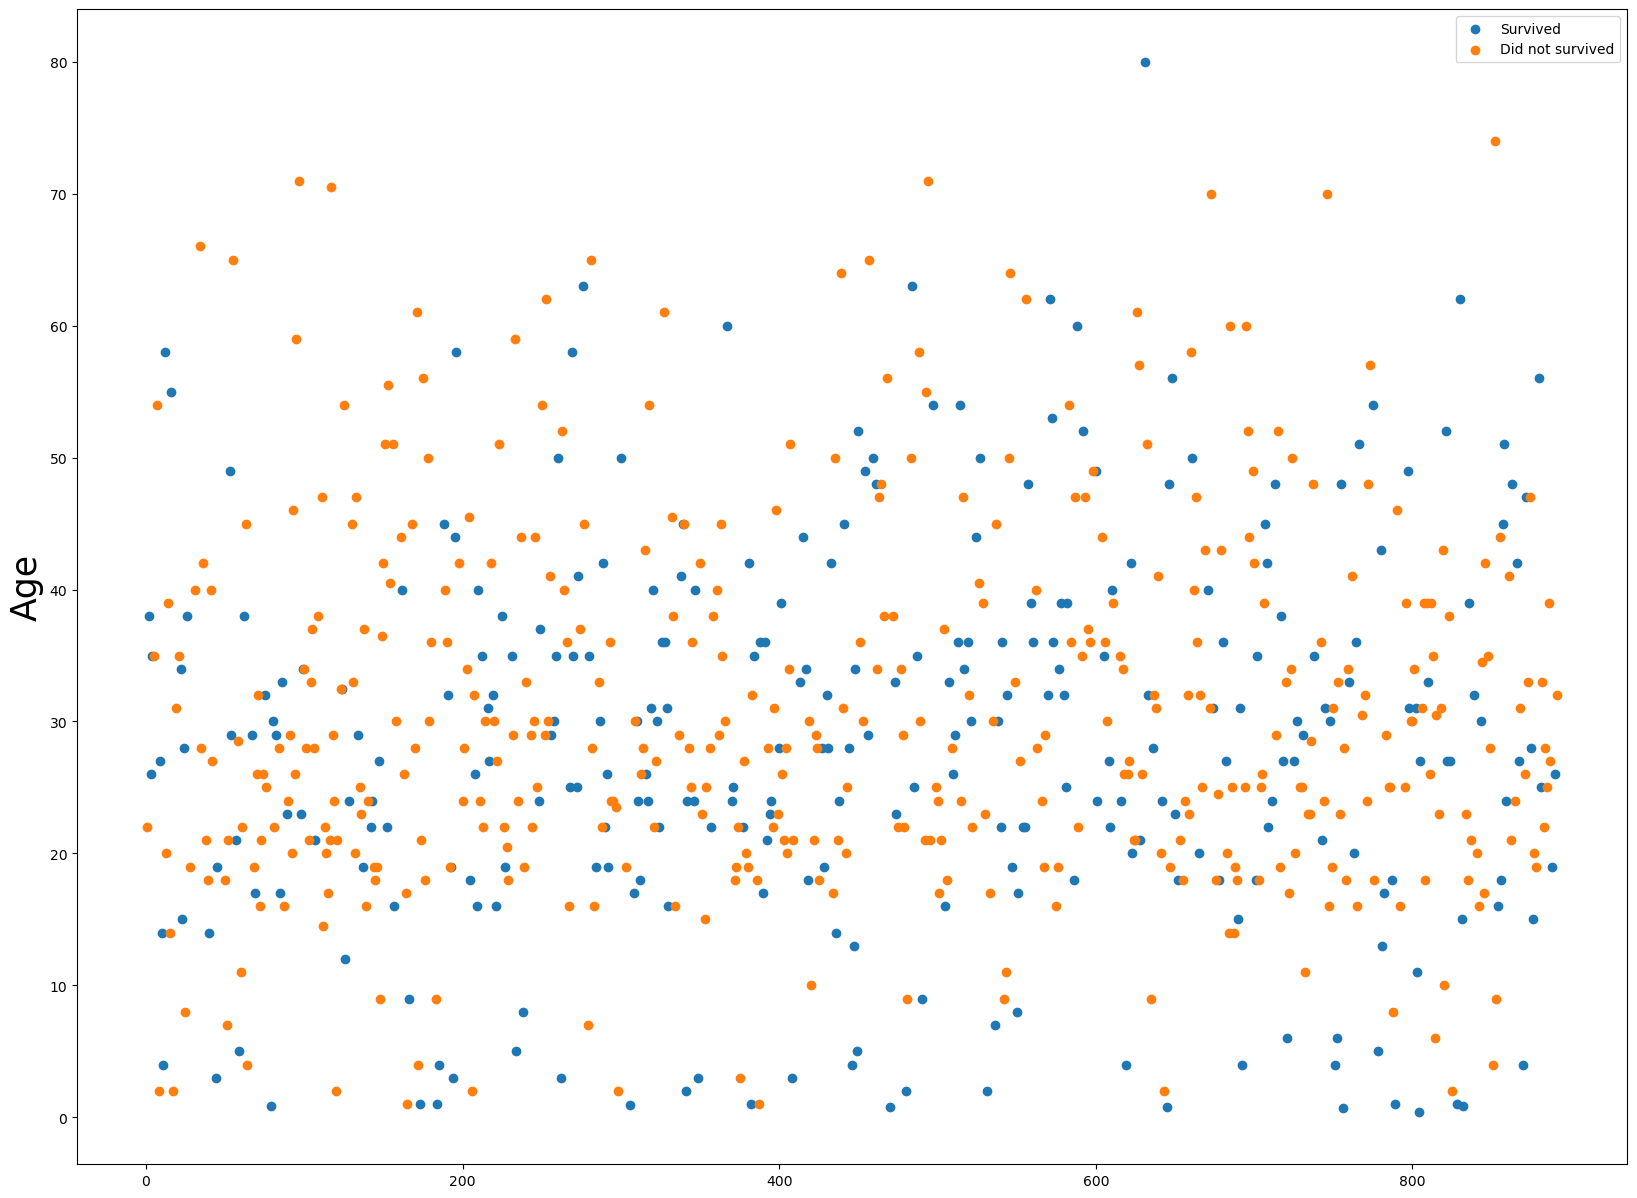

In [15]:
fig , ax= plt.subplots(figsize=(20,15))
ax.scatter(df_train["PassengerId"][df_train["Survived"] == 1],
            df_train["Age"][df_train["Survived"] == 1], label="Survived")
ax.scatter( df_train["PassengerId"][df_train["Survived"] == 0],
            df_train["Age"][df_train["Survived"] == 0], label="Did not survived")
ax.set_ylabel("Age", fontsize=25)
ax.legend()
plt.show()


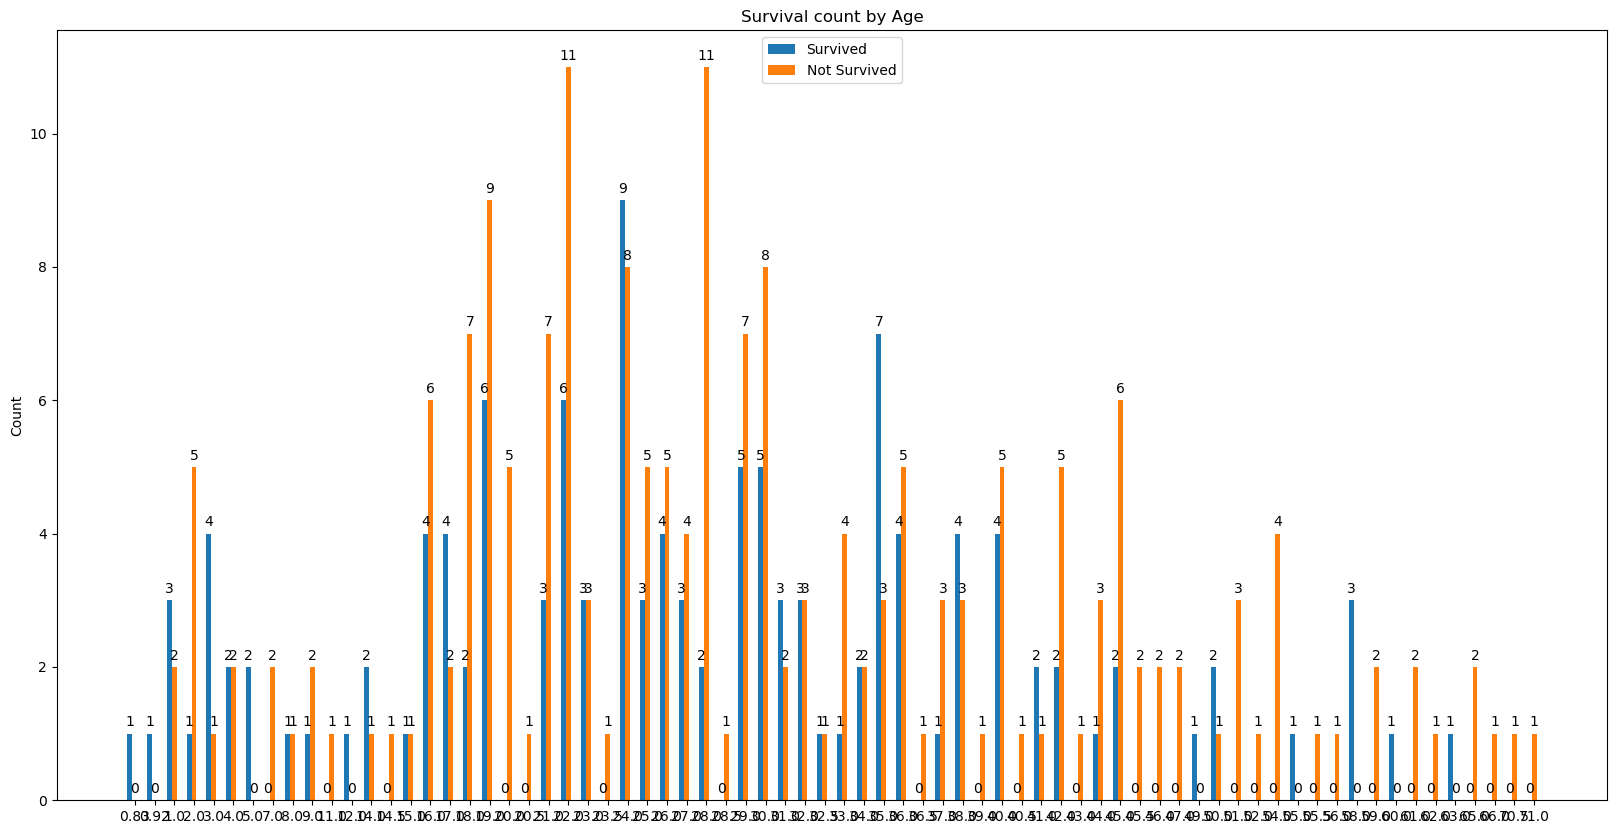

In [16]:
PlotSurvCorrelation(df_train.head(400),"Age")

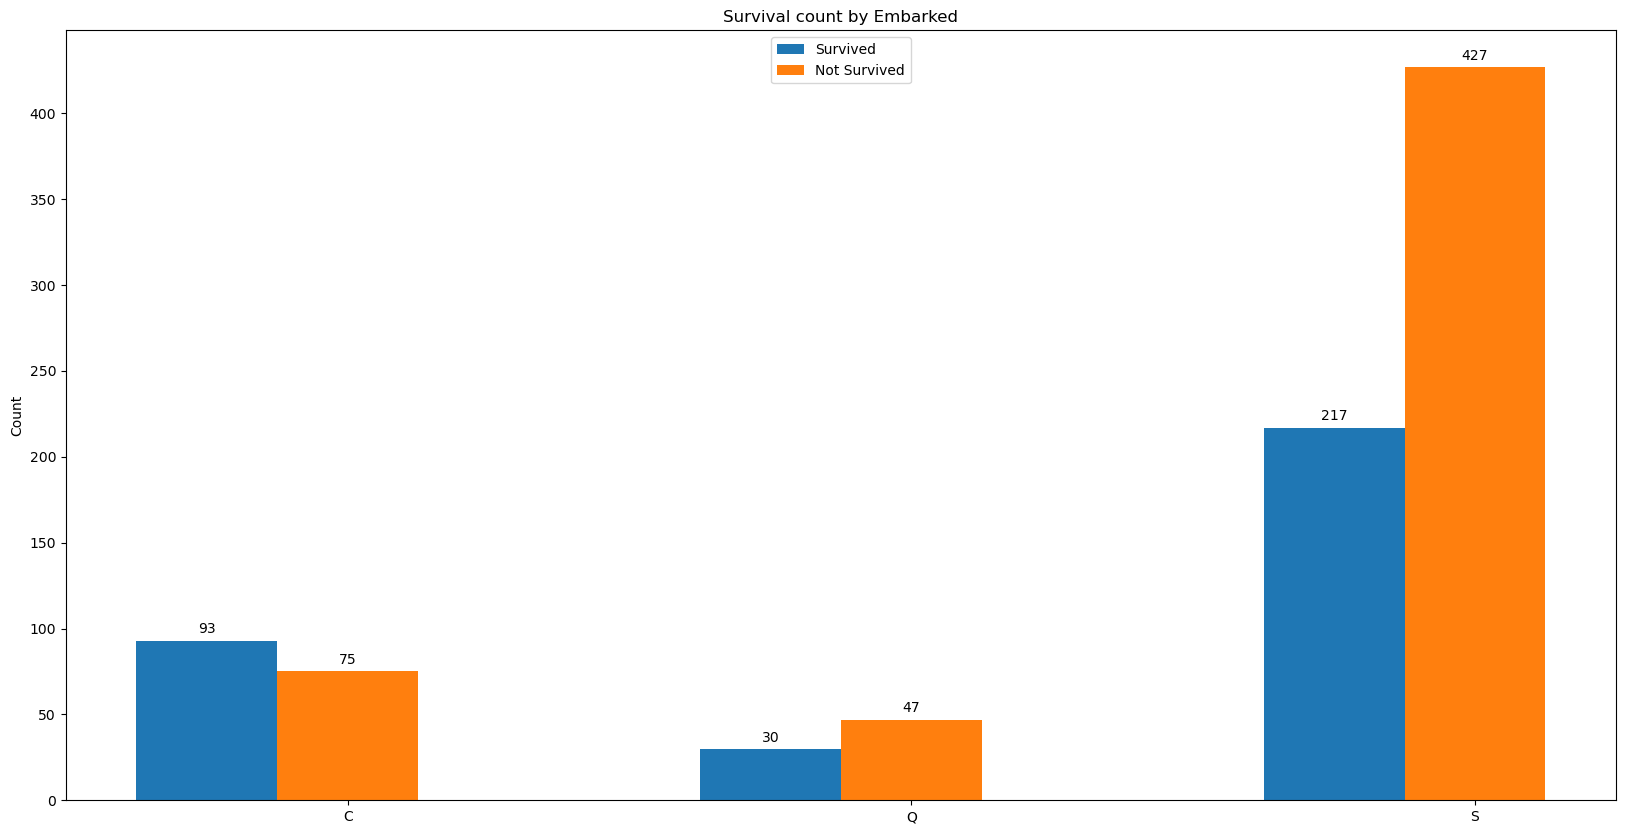

In [17]:
PlotSurvCorrelation(df_train, "Embarked")

# Dataset processing and cleaning

Use the custom transformer to process the dataset in a simple way 
###### 
Separing the label and the rest of the features in 'y' and 'X' datasets

In [18]:
#Set an instance of the data processor with the transformers and the columns
processor = FinalDataProcessor(imputer=SimpleImputer(strategy="most_frequent"),
                              scaler=Normalizer(),
                              encoder=OneHotEncoder(handle_unknown="ignore"),
                              to_encod_cols=["Pclass", "Sex", 'Embarked'],
                              to_scal_cols = ["Age", "SibSp", "Parch", "Fare"])

In [19]:
#Transform the datasets and saving the label as 'y'
X = processor.fit_transform(df_train)
X_test = processor.transform(df_test)
y = df_train["Survived"].copy()

In [20]:
X

,num__Age,num__SibSp,num__Parch,num__Fare,cat__Pclass_1,cat__Pclass_2,cat__Pclass_3,cat__Sex_female,cat__Sex_male,cat__Embarked_C,cat__Embarked_Q,cat__Embarked_S
0,0.948873,0.043131,0.000000,0.312697,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,0.470381,0.012378,0.000000,0.882377,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.956551,0.000000,0.000000,0.291564,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,0.550270,0.015722,0.000000,0.834839,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.974555,0.000000,0.000000,0.224148,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,0.901002,0.000000,0.000000,0.433816,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
887,0.535052,0.000000,0.000000,0.844819,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
888,0.713672,0.029736,0.059473,0.697317,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
889,0.654931,0.000000,0.000000,0.755689,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [21]:
X_test

,num__Age,num__SibSp,num__Parch,num__Fare,cat__Pclass_1,cat__Pclass_2,cat__Pclass_3,cat__Sex_female,cat__Sex_male,cat__Embarked_C,cat__Embarked_Q,cat__Embarked_S
0,0.975204,0.000000,0.000000,0.221306,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,0.988871,0.021040,0.000000,0.147279,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
2,0.988012,0.000000,0.000000,0.154377,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.952194,0.000000,0.000000,0.305495,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,0.871684,0.039622,0.039622,0.486855,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
413,0.948089,0.000000,0.000000,0.318005,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
414,0.337158,0.000000,0.000000,0.941448,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
415,0.982727,0.000000,0.000000,0.185059,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
416,0.948089,0.000000,0.000000,0.318005,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [22]:
countNan(X)
countNan(X_test)

___________________________
___________________________


## Process the Name attribute

As the 'Name' attribute is more complex it requires a deeper processing 

In [23]:
#Applies the TextProcess function to simplify the Name attribute
X = pd.concat([X, pd.DataFrame(df_train["Name"].map(TextProcess))],axis="columns")
X_test = pd.concat([X_test, pd.DataFrame(df_test["Name"].map(TextProcess))],axis="columns")

In [24]:
X

,num__Age,num__SibSp,num__Parch,num__Fare,cat__Pclass_1,cat__Pclass_2,cat__Pclass_3,cat__Sex_female,cat__Sex_male,cat__Embarked_C,cat__Embarked_Q,cat__Embarked_S,Name
0,0.948873,0.043131,0.000000,0.312697,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,mr
1,0.470381,0.012378,0.000000,0.882377,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,mrs
2,0.956551,0.000000,0.000000,0.291564,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,miss
3,0.550270,0.015722,0.000000,0.834839,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,mrs
4,0.974555,0.000000,0.000000,0.224148,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0.901002,0.000000,0.000000,0.433816,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,rev
887,0.535052,0.000000,0.000000,0.844819,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,miss
888,0.713672,0.029736,0.059473,0.697317,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,miss
889,0.654931,0.000000,0.000000,0.755689,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,mr


In [25]:
X_test

,num__Age,num__SibSp,num__Parch,num__Fare,cat__Pclass_1,cat__Pclass_2,cat__Pclass_3,cat__Sex_female,cat__Sex_male,cat__Embarked_C,cat__Embarked_Q,cat__Embarked_S,Name
0,0.975204,0.000000,0.000000,0.221306,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,mr
1,0.988871,0.021040,0.000000,0.147279,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,mrs
2,0.988012,0.000000,0.000000,0.154377,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,mr
3,0.952194,0.000000,0.000000,0.305495,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,mr
4,0.871684,0.039622,0.039622,0.486855,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,mrs
...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,0.948089,0.000000,0.000000,0.318005,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,mr
414,0.337158,0.000000,0.000000,0.941448,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,dona
415,0.982727,0.000000,0.000000,0.185059,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,mr
416,0.948089,0.000000,0.000000,0.318005,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,mr


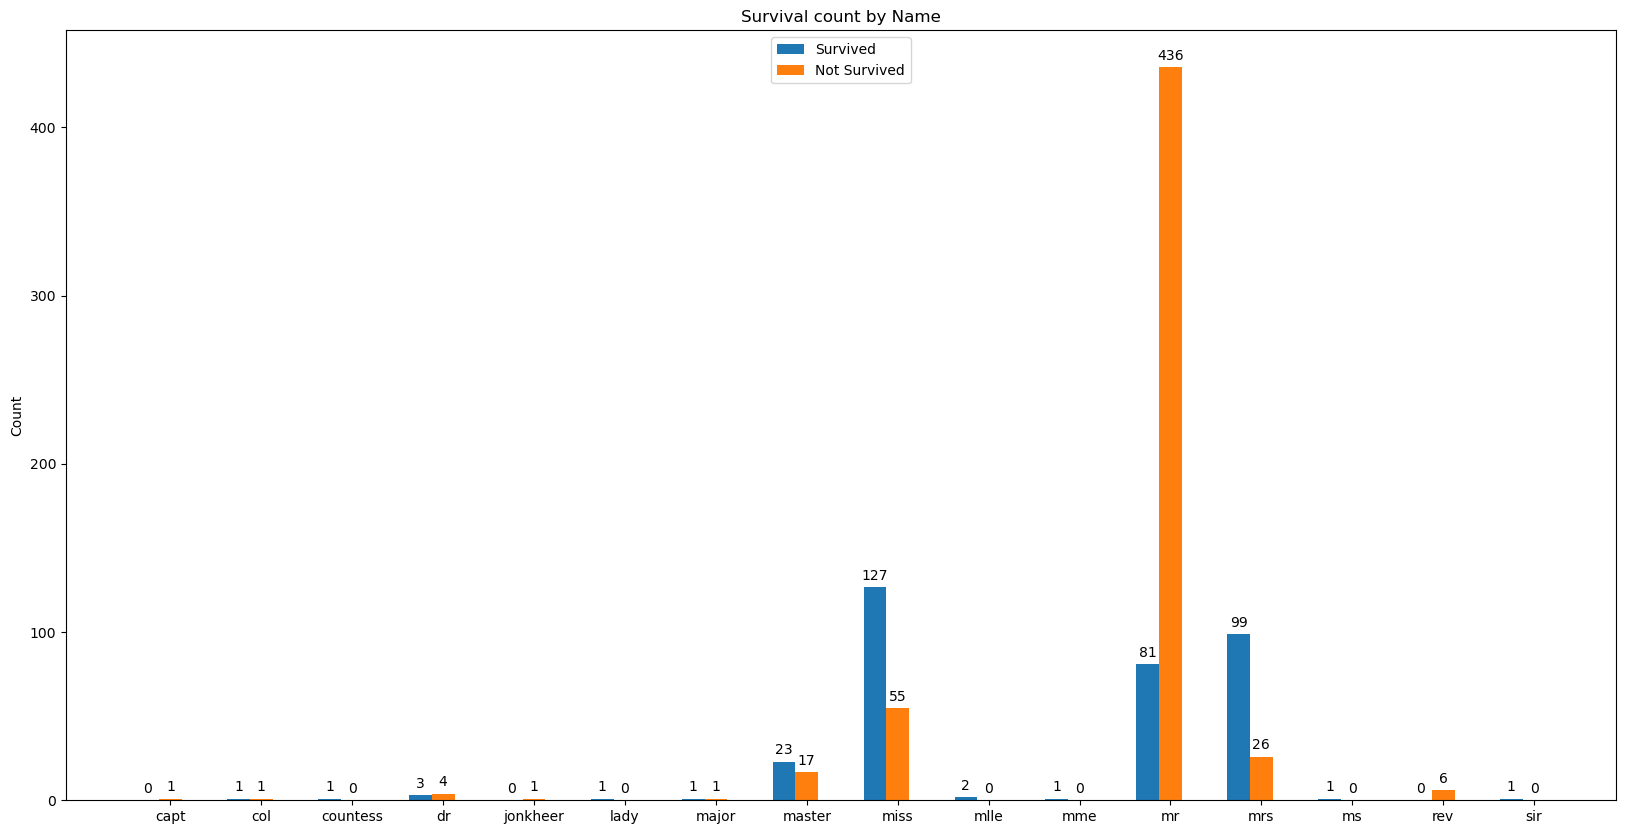

In [26]:
PlotSurvCorrelation(pd.concat([pd.DataFrame(df_train["Name"].map(TextProcess)), y], axis="columns"), "Name")

In [27]:
#Apply encoding to the Name attribute
processed_name = processor.encoder.fit_transform(np.array(X["Name"]).reshape(-1,1)).toarray()
X.drop(["Name"], inplace=True,axis=1)
X = pd.concat([X, pd.DataFrame(processed_name, columns=processor.encoder.get_feature_names_out())],axis="columns")
X

,num__Age,num__SibSp,num__Parch,num__Fare,cat__Pclass_1,cat__Pclass_2,cat__Pclass_3,cat__Sex_female,cat__Sex_male,cat__Embarked_C,...,x0_master,x0_miss,x0_mlle,x0_mme,x0_mr,x0_mrs,x0_ms,x0_rev,x0_sir,x0_None
0,0.948873,0.043131,0.000000,0.312697,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.470381,0.012378,0.000000,0.882377,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.956551,0.000000,0.000000,0.291564,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.550270,0.015722,0.000000,0.834839,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.974555,0.000000,0.000000,0.224148,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0.901002,0.000000,0.000000,0.433816,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
887,0.535052,0.000000,0.000000,0.844819,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
888,0.713672,0.029736,0.059473,0.697317,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
889,0.654931,0.000000,0.000000,0.755689,1.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [28]:
processed_name = processor.encoder.transform(np.array(X_test["Name"]).reshape(-1,1)).toarray()
X_test.drop("Name",inplace=True,axis=1)
X_test = pd.concat([X_test, pd.DataFrame(processed_name, columns=processor.encoder.get_feature_names_out())],axis="columns")
X_test

,num__Age,num__SibSp,num__Parch,num__Fare,cat__Pclass_1,cat__Pclass_2,cat__Pclass_3,cat__Sex_female,cat__Sex_male,cat__Embarked_C,...,x0_master,x0_miss,x0_mlle,x0_mme,x0_mr,x0_mrs,x0_ms,x0_rev,x0_sir,x0_None
0,0.975204,0.000000,0.000000,0.221306,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.988871,0.021040,0.000000,0.147279,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.988012,0.000000,0.000000,0.154377,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.952194,0.000000,0.000000,0.305495,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.871684,0.039622,0.039622,0.486855,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,0.948089,0.000000,0.000000,0.318005,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
414,0.337158,0.000000,0.000000,0.941448,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
415,0.982727,0.000000,0.000000,0.185059,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
416,0.948089,0.000000,0.000000,0.318005,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


### Exclude columns with too little positive values

In [29]:
#Select the columns with less than 41 positive values to simplify the dataset and prevent overfitting
columns = []
for name in processor.encoder.get_feature_names_out():
    if X[name].value_counts()[1] < 41:
        columns.append(name)

columns

['x0_capt',
 'x0_col',
 'x0_countess',
 'x0_dr',
 'x0_jonkheer',
 'x0_lady',
 'x0_major',
 'x0_master',
 'x0_mlle',
 'x0_mme',
 'x0_ms',
 'x0_rev',
 'x0_sir',
 'x0_None']

In [30]:
X.drop(columns, axis=1, inplace=True)
X

,num__Age,num__SibSp,num__Parch,num__Fare,cat__Pclass_1,cat__Pclass_2,cat__Pclass_3,cat__Sex_female,cat__Sex_male,cat__Embarked_C,cat__Embarked_Q,cat__Embarked_S,x0_miss,x0_mr,x0_mrs
0,0.948873,0.043131,0.000000,0.312697,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.470381,0.012378,0.000000,0.882377,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.956551,0.000000,0.000000,0.291564,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,0.550270,0.015722,0.000000,0.834839,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.974555,0.000000,0.000000,0.224148,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0.901002,0.000000,0.000000,0.433816,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
887,0.535052,0.000000,0.000000,0.844819,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
888,0.713672,0.029736,0.059473,0.697317,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
889,0.654931,0.000000,0.000000,0.755689,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0


In [31]:
X_test.drop(columns, axis=1, inplace=True)
X_test

,num__Age,num__SibSp,num__Parch,num__Fare,cat__Pclass_1,cat__Pclass_2,cat__Pclass_3,cat__Sex_female,cat__Sex_male,cat__Embarked_C,cat__Embarked_Q,cat__Embarked_S,x0_miss,x0_mr,x0_mrs
0,0.975204,0.000000,0.000000,0.221306,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.988871,0.021040,0.000000,0.147279,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.988012,0.000000,0.000000,0.154377,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.952194,0.000000,0.000000,0.305495,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0.871684,0.039622,0.039622,0.486855,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,0.948089,0.000000,0.000000,0.318005,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
414,0.337158,0.000000,0.000000,0.941448,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
415,0.982727,0.000000,0.000000,0.185059,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
416,0.948089,0.000000,0.000000,0.318005,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


## Process Ticket attribute 

Same thing with the Ticket attribute
###### 
As it is unique for each passenger, we will need to find patterns that could be useful to our model
###### 
Starting with the prefix in the ticket

In [32]:
train_tickets_prefixes = {}
test_tickets_prefixes = {}

#Use regular expressions to get the suffix of the ticket and create a dictionary with the count 
for train_ticket,test_ticket in zip(df_train['Ticket'].unique(), df_test['Ticket']):
    train_text_ticket = re.search(r'\w+/*.* ', train_ticket)
    test_text_ticket = re.search(r'\w+/*.* ', test_ticket)
    if train_text_ticket is not None: 
        if train_text_ticket[0] not in train_tickets_prefixes: 
            train_tickets_prefixes[train_text_ticket[0]]=1
        else:
            train_tickets_prefixes[train_text_ticket[0]]+=1
    if test_text_ticket is not None: 
        if test_text_ticket[0] not in test_tickets_prefixes: 
            test_tickets_prefixes[test_text_ticket[0]]=1
        else:
            test_tickets_prefixes[test_text_ticket[0]]+=1
print('Train ticket prefixes: ')
print(train_tickets_prefixes)
print('Count: ', len(train_tickets_prefixes))
print()
print('Test ticket prefixes: ')
print(test_tickets_prefixes)
print('Count: ', len(test_tickets_prefixes))

Train ticket prefixes: 
{'A/5 ': 8, 'PC ': 27, 'STON/O2. ': 3, 'PP ': 2, 'A/5. ': 6, 'C.A. ': 16, 'A./5. ': 1, 'SC/Paris ': 2, 'S.C./A.4. ': 1, 'A/4. ': 2, 'CA ': 1, 'S.P. ': 1, 'S.O.C. ': 1, 'SO/C ': 1, 'W./C. ': 3, 'SOTON/OQ ': 4, 'W.E.P. ': 1, 'STON/O 2. ': 7, 'A4. ': 1, 'C ': 3, 'SOTON/O.Q. ': 5, 'SC/PARIS ': 3, 'S.O.P. ': 1, 'A.5. ': 2, 'Fa ': 1, 'CA. ': 1, 'F.C.C. ': 3, 'W/C ': 1, 'SW/PP ': 1, 'SCO/W ': 1, 'P/PP ': 1, 'SC ': 1, 'SC/AH ': 1, 'A/S ': 1, 'SC/AH Basle ': 1, 'A/4 ': 1}
Count:  36

Test ticket prefixes: 
{'A/4 ': 3, 'W.E.P. ': 1, 'SC/PARIS ': 6, 'STON/O2. ': 1, 'PC ': 32, 'C ': 3, 'A/5. ': 3, 'SC/AH ': 2, 'C.A. ': 19, 'W./C. ': 5, 'SOTON/O.Q. ': 8, 'STON/O 2. ': 2, 'SC/A.3 ': 1, 'F.C.C. ': 4, 'F.C. ': 2, 'A./5. ': 1, 'PP ': 1, 'STON/OQ. ': 1, 'SOTON/OQ ': 1, 'CA ': 4, 'SC/A4 ': 1, 'S.O./P.P. ': 4, 'CA. ': 4, 'S.O.C. ': 2, 'SOTON/O2 ': 1, 'AQ/4 ': 1, 'A. 2. ': 1, 'SC ': 1, 'A/5 ': 2, 'SC/Paris ': 1, 'LP ': 1, 'AQ/3. ': 1, 'S.C./PARIS ': 1, 'A.5. ': 1}
Count:  34


In [33]:
df_prefix = pd.DataFrame(data=train_tickets_prefixes, index=['Count']).transpose()
df_prefix

,Count
A/5,8
PC,27
STON/O2.,3
PP,2
A/5.,6
C.A.,16
A./5.,1
SC/Paris,2
S.C./A.4.,1
A/4.,2


<Axes: >

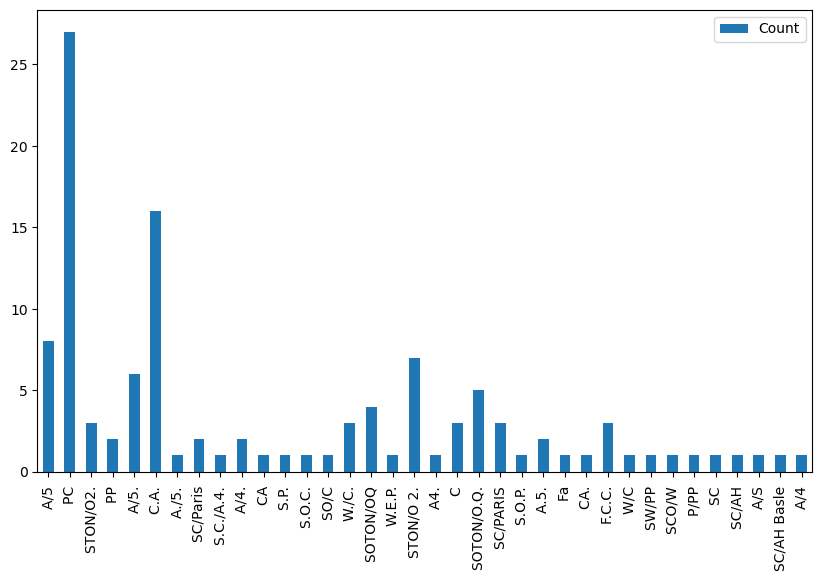

In [34]:
df_prefix.plot(kind='bar', figsize = (10,6) )

In [35]:
#Create a Data frame to compare the survivied attribute with the prefix existence
df_ticket = df_train[['Survived', 'Ticket']].copy()

df_ticket['Ticket prefix']=0
for i, ticket in enumerate(df_ticket['Ticket']):
    prefix = re.search(r'\w+/*.* ', ticket)
    if prefix is not None and prefix[0] in train_tickets_prefixes.keys():
        df_ticket['Ticket prefix'][i] = 1

/tmp/ipykernel_20/3454727247.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ticket['Ticket prefix'][i] = 1


In [36]:
df_ticket

,Survived,Ticket,Ticket prefix
0,0,A/5 21171,1
1,1,PC 17599,1
2,1,STON/O2. 3101282,1
3,1,113803,0
4,0,373450,0
...,...,...,...
886,0,211536,0
887,1,112053,0
888,0,W./C. 6607,1
889,1,111369,0


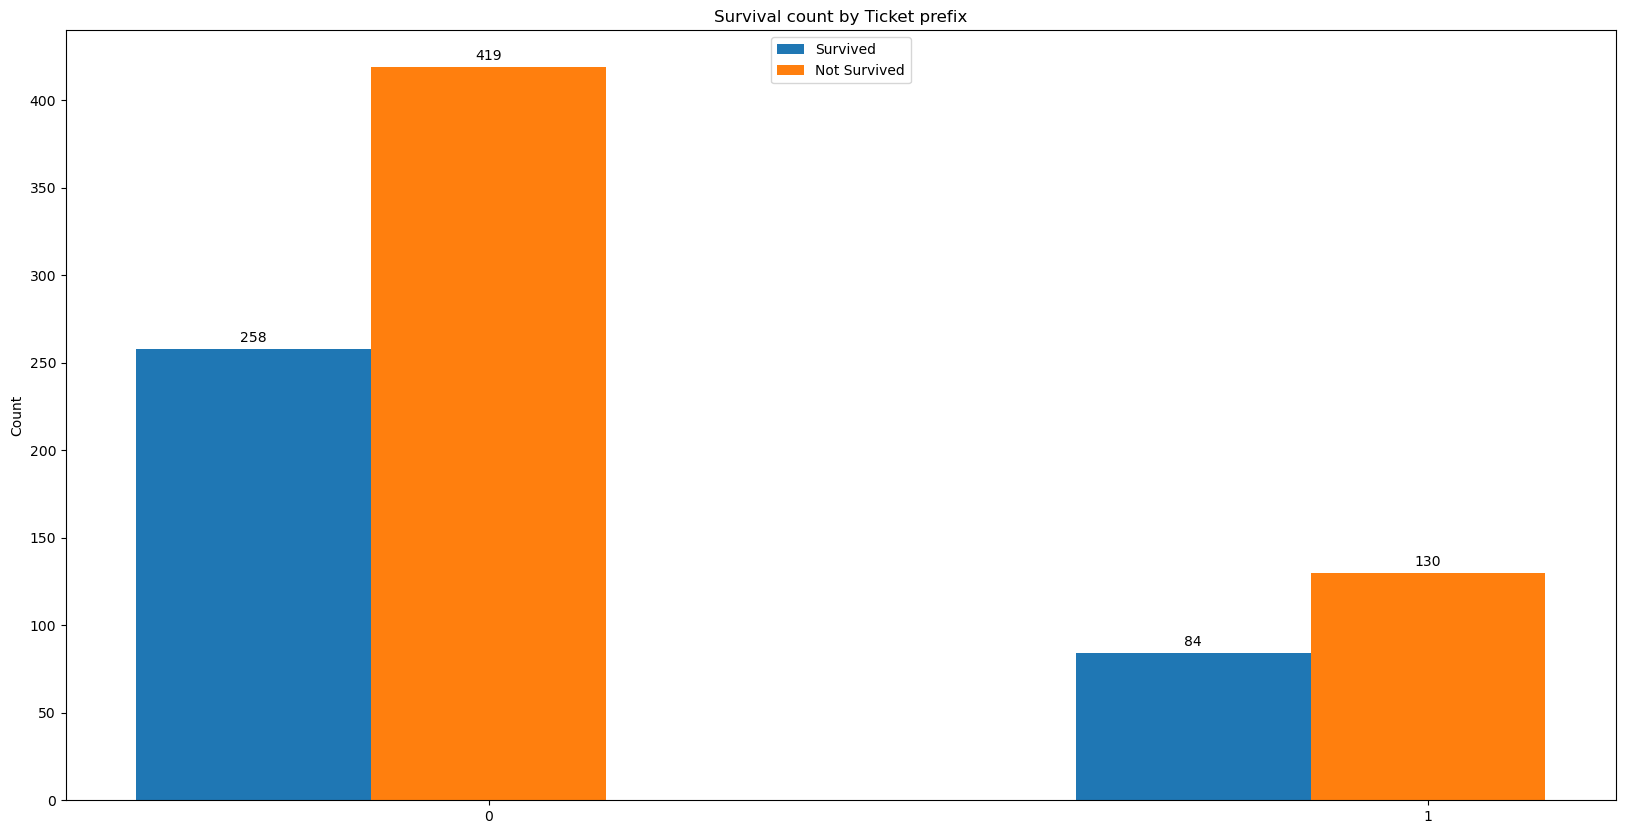

In [37]:
PlotSurvCorrelation(df_ticket, 'Ticket prefix')

Then evaluating the first number in the ticket and the length of it

In [38]:
df_ticket['Ticket Len'] = 0
df_ticket['Ticket start'] = 0
df_ticket

,Survived,Ticket,Ticket prefix,Ticket Len,Ticket start
0,0,A/5 21171,1,0,0
1,1,PC 17599,1,0,0
2,1,STON/O2. 3101282,1,0,0
3,1,113803,0,0,0
4,0,373450,0,0,0
...,...,...,...,...,...
886,0,211536,0,0,0
887,1,112053,0,0,0
888,0,W./C. 6607,1,0,0
889,1,111369,0,0,0


In [39]:
#Collect the first number and the length of the ticket sufix to contrast them with the Survived attribute
for i,ticket in enumerate(df_ticket['Ticket']):
    ticket_sufix = re.search(r'\d\d+', ticket)
    if ticket_sufix is not None:
        df_ticket['Ticket Len'][i] = len(ticket_sufix[0])
        df_ticket['Ticket start'][i] = int(ticket_sufix[0][0])

/tmp/ipykernel_20/3405260857.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ticket['Ticket Len'][i] = len(ticket_sufix[0])
/tmp/ipykernel_20/3405260857.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ticket['Ticket start'][i] = int(ticket_sufix[0][0])


In [40]:
df_ticket

,Survived,Ticket,Ticket prefix,Ticket Len,Ticket start
0,0,A/5 21171,1,5,2
1,1,PC 17599,1,5,1
2,1,STON/O2. 3101282,1,7,3
3,1,113803,0,6,1
4,0,373450,0,6,3
...,...,...,...,...,...
886,0,211536,0,6,2
887,1,112053,0,6,1
888,0,W./C. 6607,1,4,6
889,1,111369,0,6,1


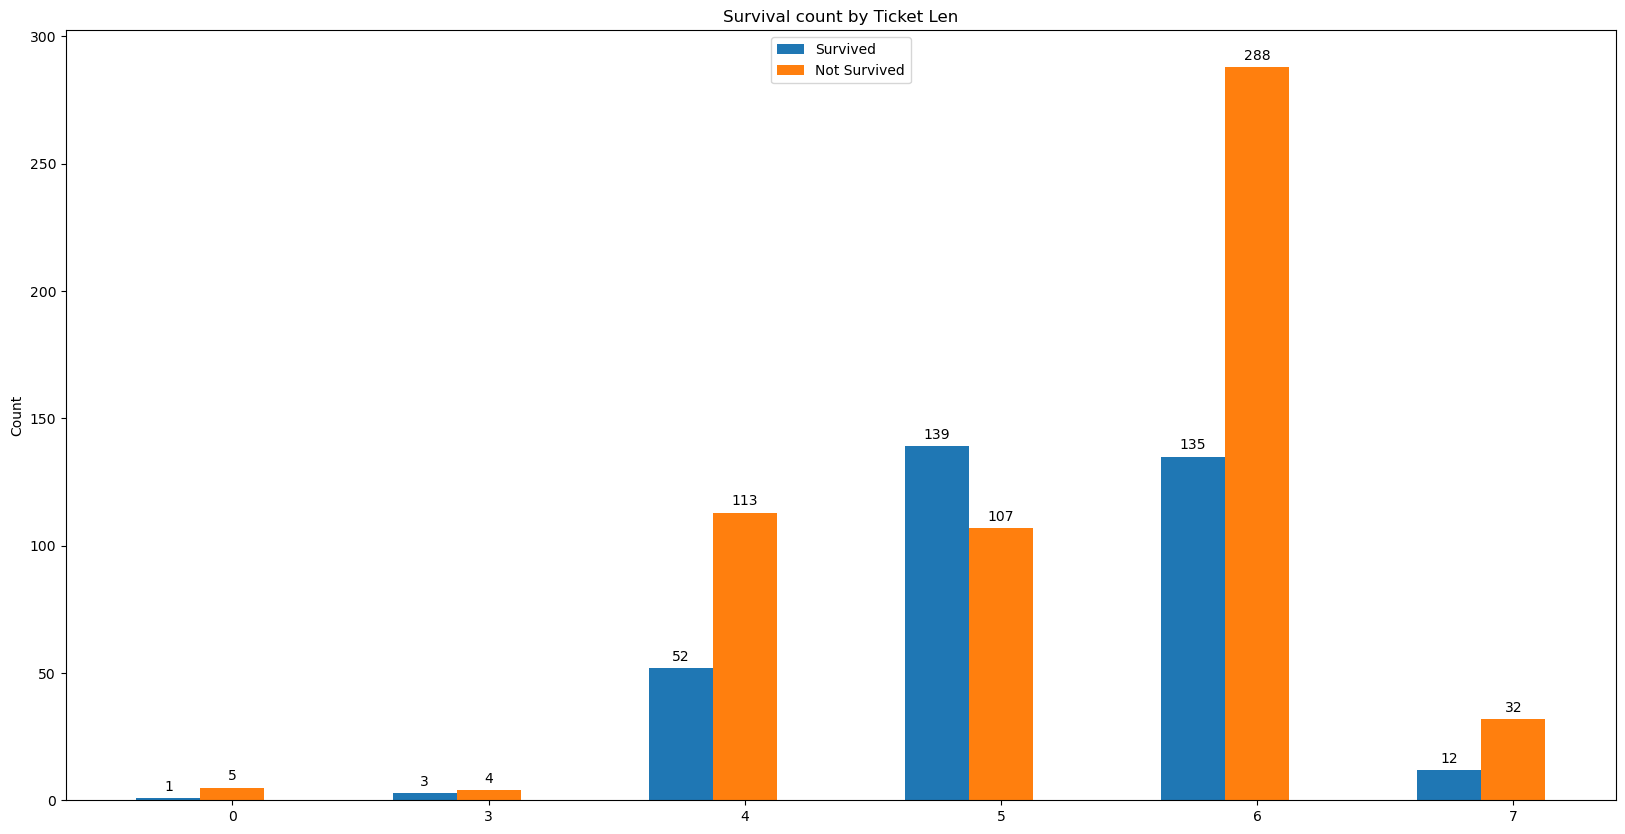

In [41]:
PlotSurvCorrelation(df_ticket, 'Ticket Len')

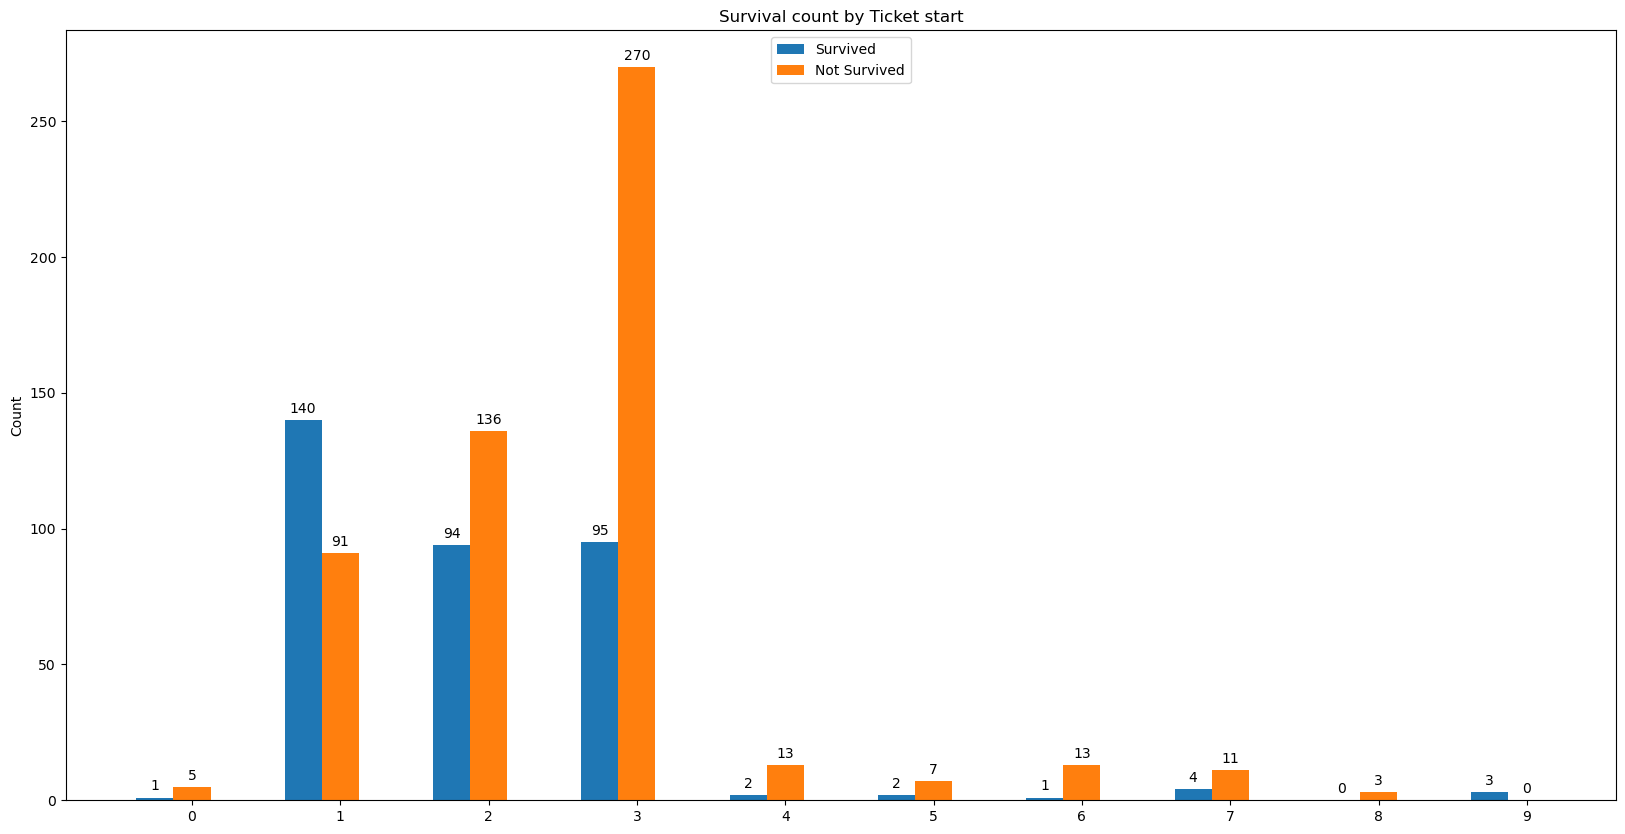

In [42]:
PlotSurvCorrelation(df_ticket, 'Ticket start')

In [43]:
#Add the created features to the X dataset
ticket_start = pd.DataFrame(processor.encoder.fit_transform(np.array(df_ticket[['Ticket start']])).toarray(), 
                           columns=['Ticket_0', 'Ticket_1', 'Ticket_2', 'Ticket_3', 'Ticket_4', 'Ticket_5', 'Ticket_6', 'Ticket_7', 'Ticket_8', 'Ticket_9'])
ticket_len = processor.scaler.transform(np.array(df_ticket['Ticket Len']).reshape(1, -1))

In [44]:
X['Ticket len']=ticket_len.reshape(-1,1)
X = pd.concat([X, ticket_start], axis='columns')

In [45]:
X

,num__Age,num__SibSp,num__Parch,num__Fare,cat__Pclass_1,cat__Pclass_2,cat__Pclass_3,cat__Sex_female,cat__Sex_male,cat__Embarked_C,...,Ticket_0,Ticket_1,Ticket_2,Ticket_3,Ticket_4,Ticket_5,Ticket_6,Ticket_7,Ticket_8,Ticket_9
0,0.948873,0.043131,0.000000,0.312697,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.470381,0.012378,0.000000,0.882377,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.956551,0.000000,0.000000,0.291564,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.550270,0.015722,0.000000,0.834839,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.974555,0.000000,0.000000,0.224148,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0.901002,0.000000,0.000000,0.433816,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
887,0.535052,0.000000,0.000000,0.844819,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
888,0.713672,0.029736,0.059473,0.697317,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
889,0.654931,0.000000,0.000000,0.755689,1.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
#All the anterior processing applied to the test dataset
df_ticket = df_test[['Ticket']].copy()

df_ticket['Ticket prefix']=0
for i, ticket in enumerate(df_ticket['Ticket']):
    prefix = re.search(r'\w+/*.* ', ticket)
    if prefix is not None and prefix[0] in train_tickets_prefixes.keys():
        df_ticket['Ticket prefix'][i] = 1
        
df_ticket['Ticket Len'] = 0
df_ticket['Ticket start'] = 0

for i,ticket in enumerate(df_ticket['Ticket']):
    ticket_sufix = re.search(r'\d\d+', ticket)
    if ticket_sufix is not None:
        df_ticket['Ticket Len'][i] = len(ticket_sufix[0])
        df_ticket['Ticket start'][i] = int(ticket_sufix[0][0])

ticket_start = pd.DataFrame(processor.encoder.transform(np.array(df_ticket[['Ticket start']])).toarray(), 
                           columns=['Ticket_0', 'Ticket_1', 'Ticket_2', 'Ticket_3', 'Ticket_4', 'Ticket_5', 'Ticket_6', 'Ticket_7', 'Ticket_8', 'Ticket_9'])
ticket_len = processor.scaler.transform(np.array(df_ticket['Ticket Len']).reshape(1, -1))

X_test['Ticket len']=ticket_len.reshape(-1,1)
X_test = pd.concat([X_test, ticket_start], axis='columns')

/tmp/ipykernel_20/275319505.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ticket['Ticket prefix'][i] = 1
/tmp/ipykernel_20/275319505.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ticket['Ticket Len'][i] = len(ticket_sufix[0])
/tmp/ipykernel_20/275319505.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ticket['Ticket start'][i] = int(ticket_sufix[0][0])


### Exclude columns with too little positive values

In [47]:
columns = []
for name in ['Ticket_0', 'Ticket_1', 'Ticket_2', 'Ticket_3', 'Ticket_4', 'Ticket_5', 'Ticket_6', 'Ticket_7', 'Ticket_8', 'Ticket_9']:
    if X[name].value_counts()[1] < 200:
        columns.append(name)

columns

['Ticket_0',
 'Ticket_4',
 'Ticket_5',
 'Ticket_6',
 'Ticket_7',
 'Ticket_8',
 'Ticket_9']

In [48]:
X.drop(columns, axis=1, inplace=True)
X

,num__Age,num__SibSp,num__Parch,num__Fare,cat__Pclass_1,cat__Pclass_2,cat__Pclass_3,cat__Sex_female,cat__Sex_male,cat__Embarked_C,cat__Embarked_Q,cat__Embarked_S,x0_miss,x0_mr,x0_mrs,Ticket len,Ticket_1,Ticket_2,Ticket_3
0,0.948873,0.043131,0.000000,0.312697,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.030868,0.0,1.0,0.0
1,0.470381,0.012378,0.000000,0.882377,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.030868,1.0,0.0,0.0
2,0.956551,0.000000,0.000000,0.291564,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.043216,0.0,0.0,1.0
3,0.550270,0.015722,0.000000,0.834839,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.037042,1.0,0.0,0.0
4,0.974555,0.000000,0.000000,0.224148,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.037042,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0.901002,0.000000,0.000000,0.433816,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.037042,0.0,1.0,0.0
887,0.535052,0.000000,0.000000,0.844819,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.037042,1.0,0.0,0.0
888,0.713672,0.029736,0.059473,0.697317,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.024695,0.0,0.0,0.0
889,0.654931,0.000000,0.000000,0.755689,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.037042,1.0,0.0,0.0


In [49]:
X_test.drop(columns, axis=1, inplace=True)
X_test

,num__Age,num__SibSp,num__Parch,num__Fare,cat__Pclass_1,cat__Pclass_2,cat__Pclass_3,cat__Sex_female,cat__Sex_male,cat__Embarked_C,cat__Embarked_Q,cat__Embarked_S,x0_miss,x0_mr,x0_mrs,Ticket len,Ticket_1,Ticket_2,Ticket_3
0,0.975204,0.000000,0.000000,0.221306,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.054816,0.0,0.0,1.0
1,0.988871,0.021040,0.000000,0.147279,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.054816,0.0,0.0,1.0
2,0.988012,0.000000,0.000000,0.154377,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.054816,0.0,1.0,0.0
3,0.952194,0.000000,0.000000,0.305495,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.054816,0.0,0.0,1.0
4,0.871684,0.039622,0.039622,0.486855,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.063952,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,0.948089,0.000000,0.000000,0.318005,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.036544,0.0,0.0,1.0
414,0.337158,0.000000,0.000000,0.941448,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.045680,1.0,0.0,0.0
415,0.982727,0.000000,0.000000,0.185059,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.063952,0.0,0.0,1.0
416,0.948089,0.000000,0.000000,0.318005,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.054816,0.0,0.0,1.0


# Divide Dataset 

In [50]:
#Divide the dataset into train-validation sets to reduce overfitting and have a better evaluation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=42)

In [51]:
print("Training Set lenght: {}".format(len(X_train)))
print("Validation Set lenght: {}".format(len(X_val)))

Training Set lenght: 712
Validation Set lenght: 179


In [52]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 331 to 102
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   num__Age         712 non-null    float64
 1   num__SibSp       712 non-null    float64
 2   num__Parch       712 non-null    float64
 3   num__Fare        712 non-null    float64
 4   cat__Pclass_1    712 non-null    float64
 5   cat__Pclass_2    712 non-null    float64
 6   cat__Pclass_3    712 non-null    float64
 7   cat__Sex_female  712 non-null    float64
 8   cat__Sex_male    712 non-null    float64
 9   cat__Embarked_C  712 non-null    float64
 10  cat__Embarked_Q  712 non-null    float64
 11  cat__Embarked_S  712 non-null    float64
 12  x0_miss          712 non-null    float64
 13  x0_mr            712 non-null    float64
 14  x0_mrs           712 non-null    float64
 15  Ticket len       712 non-null    float64
 16  Ticket_1         712 non-null    float64
 17  Ticket_2      

In [53]:
X_train

,num__Age,num__SibSp,num__Parch,num__Fare,cat__Pclass_1,cat__Pclass_2,cat__Pclass_3,cat__Sex_female,cat__Sex_male,cat__Embarked_C,cat__Embarked_Q,cat__Embarked_S,x0_miss,x0_mr,x0_mrs,Ticket len,Ticket_1,Ticket_2,Ticket_3
331,0.847475,0.000000,0.000000,0.530836,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.037042,1.0,0.0,0.0
733,0.870563,0.000000,0.000000,0.492057,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.030868,0.0,1.0,0.0
382,0.970675,0.000000,0.000000,0.240394,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.043216,0.0,0.0,1.0
704,0.956627,0.036793,0.000000,0.288982,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.037042,0.0,0.0,1.0
813,0.186580,0.124387,0.062193,0.972547,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.037042,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,0.939597,0.000000,0.000000,0.342282,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.037042,0.0,0.0,1.0
270,0.612173,0.000000,0.000000,0.790724,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.037042,1.0,0.0,0.0
860,0.944579,0.046077,0.000000,0.325034,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.037042,0.0,0.0,1.0
435,0.115861,0.008276,0.016552,0.993093,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.037042,1.0,0.0,0.0


In [54]:
X_test

,num__Age,num__SibSp,num__Parch,num__Fare,cat__Pclass_1,cat__Pclass_2,cat__Pclass_3,cat__Sex_female,cat__Sex_male,cat__Embarked_C,cat__Embarked_Q,cat__Embarked_S,x0_miss,x0_mr,x0_mrs,Ticket len,Ticket_1,Ticket_2,Ticket_3
0,0.975204,0.000000,0.000000,0.221306,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.054816,0.0,0.0,1.0
1,0.988871,0.021040,0.000000,0.147279,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.054816,0.0,0.0,1.0
2,0.988012,0.000000,0.000000,0.154377,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.054816,0.0,1.0,0.0
3,0.952194,0.000000,0.000000,0.305495,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.054816,0.0,0.0,1.0
4,0.871684,0.039622,0.039622,0.486855,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.063952,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,0.948089,0.000000,0.000000,0.318005,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.036544,0.0,0.0,1.0
414,0.337158,0.000000,0.000000,0.941448,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.045680,1.0,0.0,0.0
415,0.982727,0.000000,0.000000,0.185059,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.063952,0.0,0.0,1.0
416,0.948089,0.000000,0.000000,0.318005,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.054816,0.0,0.0,1.0


# Model construction 

We will train and test some popular models to compare them and choose the best ones to our voting classifier
###### 
Also, to improve performance, we're going to use GridSearchCV to find the hiperparameters that improve the score the best.


## Random Forest

In [55]:
#Train a Random Forest classifier with default parameters
clf_rnd = RandomForestClassifier( 
                                 n_jobs=-1, 
                                 random_state=42)
clf_rnd.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [56]:
predict(X_train, y_train, X_val, y_val, clf_rnd)

---Training set---

	-Precision Score: 0.989

	-Accuracy Score: 0.985

	-F1 Score: 0.979

	-Recall Score: 0.970

---Validation set---

	-Precision Score: 0.733

	-Accuracy Score: 0.782

	-F1 Score: 0.738

	-Recall Score: 0.743



One of the benefits of the Random Forest model is that it allow us to see which ones could be the most important features in the dataset

In [57]:
#Now we can get the most important features of our dataset
feature_importances = {name: score for name, score in zip(list(X_train), clf_rnd.feature_importances_)}

In [58]:
feature_importances_sorted = pd.Series(feature_importances).sort_values(ascending=False)
feature_importances_sorted.head(10)

num__Age           0.184325
num__Fare          0.174690
x0_mr              0.099993
cat__Sex_female    0.094163
cat__Sex_male      0.083714
num__SibSp         0.074071
num__Parch         0.052287
cat__Pclass_3      0.045614
Ticket len         0.041665
x0_mrs             0.023105
dtype: float64

In [59]:
#Create a reduced version of the datasets with the most important features
columns =  [feature for feature in feature_importances_sorted.index if feature_importances_sorted[feature] > 0.02]
X_train_reduced = X_train[columns].copy()
X_val_reduced = X_val[columns].copy()
X_test_reduced = X_test[columns].copy()

In [60]:
X_train_reduced

,num__Age,num__Fare,x0_mr,cat__Sex_female,cat__Sex_male,num__SibSp,num__Parch,cat__Pclass_3,Ticket len,x0_mrs
331,0.847475,0.530836,1.0,0.0,1.0,0.000000,0.000000,0.0,0.037042,0.0
733,0.870563,0.492057,1.0,0.0,1.0,0.000000,0.000000,0.0,0.030868,0.0
382,0.970675,0.240394,1.0,0.0,1.0,0.000000,0.000000,1.0,0.043216,0.0
704,0.956627,0.288982,1.0,0.0,1.0,0.036793,0.000000,1.0,0.037042,0.0
813,0.186580,0.972547,0.0,1.0,0.0,0.124387,0.062193,1.0,0.037042,0.0
...,...,...,...,...,...,...,...,...,...,...
106,0.939597,0.342282,0.0,1.0,0.0,0.000000,0.000000,1.0,0.037042,0.0
270,0.612173,0.790724,1.0,0.0,1.0,0.000000,0.000000,0.0,0.037042,0.0
860,0.944579,0.325034,1.0,0.0,1.0,0.046077,0.000000,1.0,0.037042,0.0
435,0.115861,0.993093,0.0,1.0,0.0,0.008276,0.016552,0.0,0.037042,0.0


### Search for the best hiperparams with GridSearchCV 

In [61]:
# Search the best hiperparameters for the dataset
param_grid = {"n_estimators": [50, 75, 100], 
               "max_leaf_nodes":[16, 32, None], 
               "min_samples_leaf":[2, 4, 8],
               "max_features": [None, "log2", "sqrt"],
               "max_depth": [16, 32, None], 
               "min_samples_split": [2, 4, 8],
               "criterion": ["gini", "entropy", "log_loss"]} # Hiperparameter combinations

clf_rnd = RandomForestClassifier(random_state=42) # Model instance
grid_rnd = GridSearchCV(clf_rnd, param_grid=param_grid, cv=5, n_jobs=-1) #Grid Search instance
start_time = time.time()
grid_rnd.fit(X_train, y_train) # Model training
end_time = time.time()
final_time = end_time-start_time #Timing the training time
print("The training lasted: {} : {} : {:.2f}".format(final_time//3600, (final_time%3600)//60, final_time%3600%60))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


The training lasted: 0.0 : 15.0 : 12.01


In [62]:
#Show the parameteres that got the best score
grid_rnd.best_params_

{'criterion': 'entropy',
 'max_depth': 32,
 'max_features': 'log2',
 'max_leaf_nodes': None,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 75}

In [63]:
predict(X_train,y_train,X_val, y_val, grid_rnd)

---Training set---

	-Precision Score: 0.952

	-Accuracy Score: 0.916

	-F1 Score: 0.880

	-Recall Score: 0.817

---Validation set---

	-Precision Score: 0.818

	-Accuracy Score: 0.821

	-F1 Score: 0.771

	-Recall Score: 0.730



In [64]:
grid_rnd.best_score_

0.8300305328474342

In [65]:
#Feature importance with the new model
feature_importances = {name: score for name, score in zip(list(X_train), grid_rnd.best_estimator_.feature_importances_)}

In [66]:
feature_importances_sorted = pd.Series(feature_importances).sort_values(ascending=False)
feature_importances_sorted.head(20)

num__Age           0.165226
num__Fare          0.149743
cat__Sex_female    0.105530
x0_mr              0.103176
cat__Sex_male      0.086287
num__SibSp         0.075050
cat__Pclass_3      0.055335
num__Parch         0.049251
Ticket len         0.039773
Ticket_1           0.024637
x0_mrs             0.024614
cat__Pclass_2      0.023333
x0_miss            0.019502
cat__Pclass_1      0.017744
cat__Embarked_S    0.015980
Ticket_3           0.015210
cat__Embarked_C    0.012734
Ticket_2           0.010201
cat__Embarked_Q    0.006677
dtype: float64

In [67]:
important_features = [feature for feature, value in zip(feature_importances_sorted.index, feature_importances_sorted) if value >0.05]
important_features

['num__Age',
 'num__Fare',
 'cat__Sex_female',
 'x0_mr',
 'cat__Sex_male',
 'num__SibSp',
 'cat__Pclass_3']

In [68]:
X_train_reduced = X_train[important_features].copy()
X_val_reduced = X_val[important_features].copy()
X_test_reduced = X_test[important_features].copy()

## Logistic Regression

In [69]:
# Train a Logistic Regression model with default parameters
clf_lr = LogisticRegression()
clf_lr.fit(X_train,y_train)

LogisticRegression()

In [70]:
predict(X_train,y_train, X_val, y_val, clf_lr)

---Training set---

	-Precision Score: 0.780

	-Accuracy Score: 0.813

	-F1 Score: 0.739

	-Recall Score: 0.701

---Validation set---

	-Precision Score: 0.754

	-Accuracy Score: 0.782

	-F1 Score: 0.727

	-Recall Score: 0.703



### Search for the best hiperparams with GridSearchCV 

In [71]:
# Hiperparameter combinations
param_grid = [{"solver":['lbfgs', 'newton-cg', 'sag'],
              "penalty": ['none', "l2"], 
              "fit_intercept": [True, False], 
              "C": [0.1, 0.5, 1, 5, 10], 
              "max_iter":[50, 100, 150, 200]
              }, 
              {'solver':['liblinear'], 
               'penalty':['l1', 'l2'], 
               "fit_intercept": [True, False], 
               "C": [0.1, 0.5, 1, 5, 10],
              "max_iter":[50, 100, 150, 200]
              }, 
               {'solver': ['saga'], 
                'penalty':['elasticnet'], 
                'l1_ratio': [0.25, 0.5, 0.25], 
                "max_iter":[50, 100, 150, 200]
               }] 
               
clf_lr = LogisticRegression(random_state=42) # Model instance
grid_lr = GridSearchCV(clf_lr, param_grid=param_grid, cv=5, n_jobs=-1) # Grid Search instance
start_time = time.time()
grid_lr.fit(X_train, y_train) # Model training
end_time = time.time()
final_time = end_time-start_time # Timing the training time
print("The training lasted: {} : {} : {:.2f}".format(final_time//3600, (final_time%3600)//60, final_time%3600%60))

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour

The training lasted: 0.0 : 0.0 : 13.92


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [72]:
# Show the parameteres that got the best score
grid_lr.best_params_

{'C': 0.1,
 'fit_intercept': True,
 'max_iter': 50,
 'penalty': 'none',
 'solver': 'lbfgs'}

In [73]:
predict(X_train,y_train, X_val, y_val, grid_lr)

---Training set---

	-Precision Score: 0.776

	-Accuracy Score: 0.817

	-F1 Score: 0.749

	-Recall Score: 0.724

---Validation set---

	-Precision Score: 0.730

	-Accuracy Score: 0.777

	-F1 Score: 0.730

	-Recall Score: 0.730



In [74]:
grid_lr.best_score_

0.8089727174234216

## Poly SVM

In [75]:
# Train a SVC model with a linear kernel with default parameters
clf_svm = SVC(kernel="linear", random_state=42)
clf_svm.fit(X_train,y_train)

SVC(kernel='linear', random_state=42)

In [76]:
predict(X_train ,y_train, X_val, y_val, clf_svm)

---Training set---

	-Precision Score: 0.739

	-Accuracy Score: 0.788

	-F1 Score: 0.706

	-Recall Score: 0.675

---Validation set---

	-Precision Score: 0.754

	-Accuracy Score: 0.782

	-F1 Score: 0.727

	-Recall Score: 0.703



### Search for the best hiperparams with GridSearchCV 

In [77]:
# Hiperparameter combinations 
param_grid = {"kernel": ["poly"], 
              "degree": [2, 3], 
              "coef0": [0, 0.1, 1, 5], 
              "C": [0.1, 1, 5], 
              "gamma": [5, 10, 15]}

clf_svm = SVC(random_state=42)# Model instance
grid_svm = GridSearchCV(clf_svm, param_grid=param_grid, n_jobs=-1, cv=5, return_train_score=True) # Grid Search instance
start_time = time.time()
grid_svm.fit(X_train, y_train) # Model training
end_time = time.time()
final_time = end_time-start_time # Timing the training time
print("The training lasted: {} : {} : {:.2f}".format(final_time//3600, (final_time%3600)//60, final_time%3600%60))

The training lasted: 0.0 : 4.0 : 55.63


In [78]:
# Show the parameteres that got the best score
grid_svm.best_params_

{'C': 0.1, 'coef0': 0, 'degree': 2, 'gamma': 10, 'kernel': 'poly'}

In [79]:
predict(X_train,y_train, X_val, y_val, grid_svm)

---Training set---

	-Precision Score: 0.873

	-Accuracy Score: 0.847

	-F1 Score: 0.773

	-Recall Score: 0.694

---Validation set---

	-Precision Score: 0.828

	-Accuracy Score: 0.821

	-F1 Score: 0.768

	-Recall Score: 0.716



In [80]:
grid_svm.best_score_

0.8146262188515709

## Gaussian SVM

In [81]:
# Train a SVC model with 'rbf' kernel with default parameters
clf_rbf = SVC(kernel="rbf", random_state=42)
clf_rbf.fit(X_train, y_train)

SVC(random_state=42)

In [82]:
predict(X_train,y_train, X_val, y_val, clf_rbf)

---Training set---

	-Precision Score: 0.898

	-Accuracy Score: 0.831

	-F1 Score: 0.736

	-Recall Score: 0.623

---Validation set---

	-Precision Score: 0.817

	-Accuracy Score: 0.799

	-F1 Score: 0.731

	-Recall Score: 0.662



### Search for the best hiperparams with GridSearchCV 

In [83]:
# Hiperparameter combinations
param_grid = {"kernel": ["rbf"], 
            "gamma": [0.01, 0.1, 1, 5, 10, 20, 'scale', 'auto'], 
              "C": [0.01, 0.1, 1, 4, 5, 10, 20],
             "random_state": [42]}

clf_rbf = SVC() # Model instance
grid_rbf = GridSearchCV(clf_rbf, param_grid=param_grid, n_jobs=-1, cv=5, return_train_score=True) # Grid Search instance
start_time = time.time()
grid_rbf.fit(X_train, y_train) # Model training
end_time = time.time()
final_time = end_time-start_time # Timing the training time
print("The training lasted: {} : {} : {:.2f}".format(final_time//3600, (final_time%3600)//60, final_time%3600%60)) 

The training lasted: 0.0 : 0.0 : 4.83


In [84]:
# Show the parameteres that got the best score
grid_rbf.best_params_

{'C': 4, 'gamma': 1, 'kernel': 'rbf', 'random_state': 42}

In [85]:
predict(X_train,y_train, X_val, y_val, grid_rbf)

---Training set---

	-Precision Score: 0.905

	-Accuracy Score: 0.850

	-F1 Score: 0.771

	-Recall Score: 0.672

---Validation set---

	-Precision Score: 0.812

	-Accuracy Score: 0.810

	-F1 Score: 0.754

	-Recall Score: 0.703



In [86]:
grid_rbf.best_score_

0.818851570964247

## Naive Bayes 

In [87]:
# Train a Naive Bayes model with default parameters
clf_nb = BernoulliNB()
clf_nb.fit(X_train ,y_train)

BernoulliNB()

In [88]:
predict(X_train,y_train, X_val, y_val, clf_nb)

---Training set---

	-Precision Score: 0.729

	-Accuracy Score: 0.789

	-F1 Score: 0.715

	-Recall Score: 0.701

---Validation set---

	-Precision Score: 0.750

	-Accuracy Score: 0.788

	-F1 Score: 0.740

	-Recall Score: 0.730



### Search for the best hiperparams with GridSearchCV 

In [89]:
param_grid = {"alpha":[1.0e-10, 5e-10, 0, 1, 5]} # Hiperparameter combinations


clf_nb = BernoulliNB() # Model instance
grid_nb = GridSearchCV(clf_nb, param_grid=param_grid, n_jobs=-1, cv=5) # Grid Search instance
start_time = time.time() 
grid_nb.fit(X_train, y_train) # Model training
end_time = time.time()
final_time = end_time-start_time # Timing the training time
print("The training lasted: {} : {} : {:.2f}".format(final_time//3600, (final_time%3600)//60, final_time%3600%60))

The training lasted: 0.0 : 0.0 : 0.10


/opt/conda/lib/python3.10/site-packages/sklearn/naive_bayes.py:629: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/naive_bayes.py:629: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/naive_bayes.py:629: FutureWarning: The default val

In [90]:
# Show the parameteres that got the best score
grid_nb.best_params_

{'alpha': 5}

In [91]:
predict(X_train,y_train, X_val, y_val, grid_nb)

---Training set---

	-Precision Score: 0.729

	-Accuracy Score: 0.789

	-F1 Score: 0.715

	-Recall Score: 0.701

---Validation set---

	-Precision Score: 0.750

	-Accuracy Score: 0.788

	-F1 Score: 0.740

	-Recall Score: 0.730



In [92]:
grid_nb.best_score_

0.7850783019797104

## Ridge Classifier

In [93]:
# Train a Ridge classifier with default parameters
rdg_clf = RidgeClassifier(random_state=42)
rdg_clf.fit(X_train, y_train)

RidgeClassifier(random_state=42)

In [94]:
predict(X_train, y_train, X_val, y_val, rdg_clf)

---Training set---

	-Precision Score: 0.765

	-Accuracy Score: 0.813

	-F1 Score: 0.746

	-Recall Score: 0.728

---Validation set---

	-Precision Score: 0.764

	-Accuracy Score: 0.799

	-F1 Score: 0.753

	-Recall Score: 0.743



### Search for the best hiperparams with GridSearchCV

In [95]:
# Hiperparameter combinations
param_grid = [{'alpha':[0.5, 1, 2, 4], 
              'solver': ['svd', 'cholesky', 'sparse_cg', 'lsqr', 'sag', 'auto'], 
              'tol': [1e-4, 1e-3, 1e-2], 
              'positive':[False]}, 
              {'alpha':[0.5, 1, 2 , 4], 
              'solver':['lbfgs', 'auto'], 
              'positive': [True], 
              'tol': [1e-4, 1e-3, 1e-2],
              }]

clf_rdg = RidgeClassifier(random_state=42) # Model instance
grid_rdg=GridSearchCV(clf_rdg, param_grid=param_grid, cv=5, n_jobs=-1) # Grid Search instance
start_time = time.time()
grid_rdg.fit(X_train, y_train) # Model training
end_time = time.time()
final_time = end_time-start_time # Timing the training time
print("The training lasted: {} : {} : {:.2f}".format(final_time//3600, (final_time%3600)//60, final_time%3600%60))

The training lasted: 0.0 : 0.0 : 1.64


In [96]:
# Show the parameteres that got the best score
grid_rdg.best_params_

{'alpha': 0.5, 'positive': False, 'solver': 'sag', 'tol': 0.01}

In [97]:
predict(X_train, y_train, X_val, y_val, grid_rdg)

---Training set---

	-Precision Score: 0.762

	-Accuracy Score: 0.812

	-F1 Score: 0.744

	-Recall Score: 0.728

---Validation set---

	-Precision Score: 0.771

	-Accuracy Score: 0.799

	-F1 Score: 0.750

	-Recall Score: 0.730



In [98]:
grid_rdg.best_score_

0.8005121638924455

## SGD Classifier

In [99]:
# Train a SGD classifier with default parameters
clf_sgd = SGDClassifier(random_state=42)
clf_sgd.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [100]:
predict(X_train, y_train, X_val, y_val, clf_sgd)

---Training set---

	-Precision Score: 0.868

	-Accuracy Score: 0.781

	-F1 Score: 0.629

	-Recall Score: 0.493

---Validation set---

	-Precision Score: 0.844

	-Accuracy Score: 0.760

	-F1 Score: 0.639

	-Recall Score: 0.514



### Search for the best hiperparams with GridSearchCV

In [101]:
# Hiperparameter combinations
param_grid=[{'loss' :['hinge', 'log_loss', 'modified_huber', 'squared_hinge', 
                      'perceptron', 'squared_error', 'squared_epsilon_insensitive'], 
            'penalty':['l2', 'l1',None], 
            'alpha' : [0.1, 1, 5, 10], 
            'learning_rate': ['constant', 'optimal', 'invscaling'],
            'eta0' : [0.1, 1, 5, 10],
            'early_stopping': [True, False]},
            {'loss' : ['huber', 'epsilon_insensitive'], 
             'penalty' : ['l2', 'l1', None], 
             'alpha' : [0.1, 1, 5, 10],
             'learning_rate': ['constant', 'optimal', 'invscaling'], 
             'eta0' : [0.1, 1, 5, 10],
             'epsilon' :[0, 0.1, 1, 5, 10], 
             'early_stopping': [True, False]}]
            
clf_sgd=SGDClassifier(random_state=42) # Model instance
grid_sgd=GridSearchCV(clf_sgd, param_grid=param_grid, cv=5, n_jobs=-1) # Grid Search instance
start_time = time.time()
grid_sgd.fit(X_train, y_train) # Model training
end_time = time.time()
final_time = end_time-start_time # Timing the training time
print("The training lasted: {} : {} : {:.2f}".format(final_time//3600, (final_time%3600)//60, final_time%3600%60))

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic

The training lasted: 0.0 : 1.0 : 46.23


In [102]:
# Show the parameteres that got the best score
grid_sgd.best_params_

{'alpha': 0.1,
 'early_stopping': False,
 'eta0': 10,
 'learning_rate': 'invscaling',
 'loss': 'hinge',
 'penalty': None}

In [103]:
predict(X_train, y_train, X_val, y_val, grid_sgd)

---Training set---

	-Precision Score: 0.718

	-Accuracy Score: 0.795

	-F1 Score: 0.734

	-Recall Score: 0.750

---Validation set---

	-Precision Score: 0.718

	-Accuracy Score: 0.777

	-F1 Score: 0.737

	-Recall Score: 0.757



In [104]:
grid_sgd.best_score_

0.8117994681374963

## Perceptron

In [105]:
# Train a Perceptron model with default parameters
clf_pct = Perceptron(random_state=42)
clf_pct.fit(X_train, y_train)

Perceptron(random_state=42)

In [106]:
predict(X_train, y_train, X_val, y_val, clf_pct)

---Training set---

	-Precision Score: 0.578

	-Accuracy Score: 0.697

	-F1 Score: 0.641

	-Recall Score: 0.720

---Validation set---

	-Precision Score: 0.644

	-Accuracy Score: 0.732

	-F1 Score: 0.707

	-Recall Score: 0.784



### Search for the best hiperparams with GridSearchCV

In [107]:
# Hiperparameter combinations
param_grid=[{'penalty':['l1', 'l2', None], 
            'alpha' : [0,0.01, 0.001, 0.0001, 0.1, 1, 5, 10], 
            'eta0' : [0.1, 1, 5, 10], 
            'early_stopping' :[True, False]}, 
            {'penalty':['elasticnet'], 
            'alpha' : [0,0.01, 0.001, 0.0001, 0.1, 1, 5, 10], 
            'eta0' : [0.1, 1, 5, 10], 
            'early_stopping' :[True, False], 
            'l1_ratio':[0.25, 0.5, 0.25]}
           ]      

clf_pct = Perceptron(random_state=42) # Model instance
grid_pct = GridSearchCV(clf_pct, param_grid=param_grid, cv=5, n_jobs=-1) # Grid Search instance
start_time = time.time()
grid_pct.fit(X_train, y_train) # Model training
end_time = time.time()
final_time = end_time-start_time # Timing the training time
print("The training lasted: {} : {} : {:.2f}".format(final_time//3600, (final_time%3600)//60, final_time%3600%60))

The training lasted: 0.0 : 0.0 : 8.11


In [108]:
# Show the parameteres that got the best score
grid_pct.best_params_

{'alpha': 0.001,
 'early_stopping': True,
 'eta0': 1,
 'l1_ratio': 0.5,
 'penalty': 'elasticnet'}

In [109]:
predict(X_train, y_train, X_val, y_val, grid_pct)

---Training set---

	-Precision Score: 0.795

	-Accuracy Score: 0.805

	-F1 Score: 0.715

	-Recall Score: 0.649

---Validation set---

	-Precision Score: 0.743

	-Accuracy Score: 0.788

	-F1 Score: 0.743

	-Recall Score: 0.743



In [110]:
grid_pct.best_score_

0.7949374569092879

## Ensembles: Voting classifier

Now that all the model are trained and we checked their scores, we can choose some of them and combine them in a Voting classifier

In [111]:
#Select some classifiers, combine and train them 
clf_vote = VotingClassifier(estimators=[('Random Forest', grid_rnd.best_estimator_),
                                        ('RBF SVM', grid_rbf.best_estimator_)])
clf_vote.fit(X, y)

VotingClassifier(estimators=[('Random Forest',
                              RandomForestClassifier(criterion='entropy',
                                                     max_depth=32,
                                                     max_features='log2',
                                                     min_samples_leaf=2,
                                                     n_estimators=75,
                                                     random_state=42)),
                             ('RBF SVM', SVC(C=4, gamma=1, random_state=42))])

In [112]:
predict(X_train, y_train, X_val, y_val, clf_vote)

---Training set---

	-Precision Score: 0.956

	-Accuracy Score: 0.857

	-F1 Score: 0.773

	-Recall Score: 0.649

---Validation set---

	-Precision Score: 0.931

	-Accuracy Score: 0.866

	-F1 Score: 0.818

	-Recall Score: 0.730



# Create submission 

Now that we have our final model, it's time to make the prediction and upload it to the competition

In [113]:
final_model = clf_vote
CreateSub(df_test, X_test, final_model, "submission")

In [114]:
final_model

VotingClassifier(estimators=[('Random Forest',
                              RandomForestClassifier(criterion='entropy',
                                                     max_depth=32,
                                                     max_features='log2',
                                                     min_samples_leaf=2,
                                                     n_estimators=75,
                                                     random_state=42)),
                             ('RBF SVM', SVC(C=4, gamma=1, random_state=42))])

# Save the model

It is algo possible to save the model and load it later to compare it or conserve it for latter use

In [115]:
dump(clf_vote, '/kaggle/working/clf_vote_5.joblib')

['/kaggle/working/clf_vote_5.joblib']

## Load anterior model

In [116]:
clf_vote_1 = load('/kaggle/working/clf_vote_5.joblib')

In [117]:
clf_vote_1

VotingClassifier(estimators=[('Random Forest',
                              RandomForestClassifier(criterion='entropy',
                                                     max_depth=32,
                                                     max_features='log2',
                                                     min_samples_leaf=2,
                                                     n_estimators=75,
                                                     random_state=42)),
                             ('RBF SVM', SVC(C=4, gamma=1, random_state=42))])